#EDA
###Jessica Stoker

# Table of contents

*   [Introduction ](#sec1)

*   [Setup ](#sec2)

*   [Data Manipulation ](#sec3)
      * [Combining Dataframes ](#sec3.1)
      * [Setting up for Comparison ](#sec3.2)
      * [Prices Combined Summaries ](#sec3.3)
      * [Percent Change Summaries ](#sec3.4)
*   [Plots ](#sec4)
      * [Individual Plots ](#sec4.1)
      * [Grouped Plots ](#sec4.2)
      * [Seasonality and Trends](#sec4.3)

*   [Results of EDA](#sec5)

*   [Modeling](#sec6)
      * [ARIMA](#sec6.1)
      * [ARIMA Results Comments](#sec6.2)
      * [LSTM ](#sec6.3)
      * [Final Results ](#sec6.4)


# Business Problem <a id="sec1"></a>

Fluctuating prices in Swire’s supply chain results in lower margins. Building accurate forecasts of commodities used in production will help with procurement, production planning, and inventory management. Nate, Robyn, and I have been tasked to produce a solution to this problem. We aim to use time series forecasting methods to produce both short (3 months) and long-term (1 year) forecasts on a dashboard that can simulate profitability scenarios. Success will be measured by the ability of key stakeholders to use the dashboard and make informed decisions in the productions process, as well as the accuracy of the forecasts in the model.

In this stage of our project, we have downloaded as much historical data as possible from the sources provided. Our goal is to explore these data in hopes of getting a clearer picture of the previous fluctuations in the commodities prices. This will allow us to better create the models that will predict the future prices of these commodities.

To begin, I will begin by listing the questions that I am hoping to answer during my exploration.

1. What do these data look like?
2. What are the trends for each commodity?
3. What are the monthly averages of each commodity? 
4. What about yearly averages?
5. Are there seasonal trends for these commodities?
6. Can I compare the fluctuation in these commodities?









# Setup <a id="sec2"></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# supress the display of warning messages
import warnings
warnings.filterwarnings('ignore') 

In [7]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randrange
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from statsmodels.tsa.statespace.kalman_filter import PredictionResults
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [9]:
np.random.seed(123456)

In [10]:
# Upload files into pandas dataframes
#Sugar
sugar = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/sugar-prices-37yr.csv", index_col = 'date', parse_dates = True)
#Cotton
cotton = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/cotton-prices-45yr.csv", index_col = 'date', parse_dates = True)
#Corn
corn = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/corn-prices-59yr.csv", index_col = 'date', parse_dates = True)
#Coffee
coffee = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/coffee-prices-45yr.csv", index_col = 'date', parse_dates = True)
#Soy Bean
soybean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/soybean-prices-45yr.csv", index_col = 'date', parse_dates = True)
#Soy Bean Oil
soybean_oil = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/soybean-oil-prices-45yr.csv", index_col = 'date', parse_dates = True)
#Alumuinum
aluminum = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EDA/Aluminum-prices-20yr_rv.csv", index_col = 'Date', parse_dates = True)

# Data Manipulation <a id="sec3"></a>

There are a couple of ways that I did manipulate the data before importing the data into my notebook.

* There was a 0 value on 1/22/2007 in the Aluminum data set. I couldn't see a clear reason why this value would be 0. I assumed that this was an error. I used Excel to filter out all but the values from January of 2007 and excluded the missing value before taking the average of that month. I used that average to replace the 0 value.

* I was having a hard time parsing the correct dates with the date format that was automatically extracted from each site. I change the date format in excel to YYYY-MM-DD so that all dates were parsed correctly at import.


### Data Manipulation in Python

You can see below that there are dates that haven't happened yet included in the dataframes, these are all labeled as NA. I chose to ensure that there were no NA values that will cause me issues in plotting and viewing the data later.

In [11]:
cotton.isna()

value
date              
1972-08-22   False
1972-08-23   False
1972-08-24   False
1972-08-25   False
1972-08-28   False
...            ...
2023-03-06    True
2023-03-07    True
2023-03-08    True
2023-03-09    True
2023-03-10    True

[12718 rows x 1 columns]

In [12]:
#Drop NA rows
sugar = sugar.dropna()
cotton = cotton.dropna()
corn = corn.dropna()
cofee = coffee.dropna()
soybean = soybean.dropna()
soybean_oil = soybean_oil.dropna()
aluminum = aluminum.dropna()
#Rename value column to the comodity name for identification in combned dataframe
sugar = sugar.rename(columns={' value': 'sugar'})
cotton = cotton.rename(columns={' value': 'cotton'})
corn = corn.rename(columns={' value': 'corn'})
coffee = coffee.rename(columns={' value': 'coffee'})
soybean = soybean.rename(columns={' value': 'soybean'})
soybean_oil = soybean_oil.rename(columns={' value': 'soybean_oil'})
aluminum = aluminum.rename(columns={'Close': 'aluminum'})

### Combining dataframes <a id="sec3.1"></a>

I chose to combine these dataframes to reduce the amount of code to write and for easier comparison. You will see in the next section that this merge only combines the rows that are represented in all dataframes.

In [13]:
#Merge all dataframes into one
all_prices = pd.merge(sugar, cotton, left_index=True, right_index=True).merge(corn, left_index=True, right_index=True).merge(coffee,left_index=True, right_index=True).merge(soybean,left_index=True, right_index=True).merge(soybean_oil,left_index=True, right_index=True).merge(aluminum, left_index=True, right_index=True)

In [14]:
#Creating dataframe with monthly average
all_prices_M = all_prices.resample('M').mean()
#Creating dataframe with yearly average
all_prices_Y = all_prices.resample('Y').mean()

Text(0.5, 1.0, 'Correlation Heatmap')

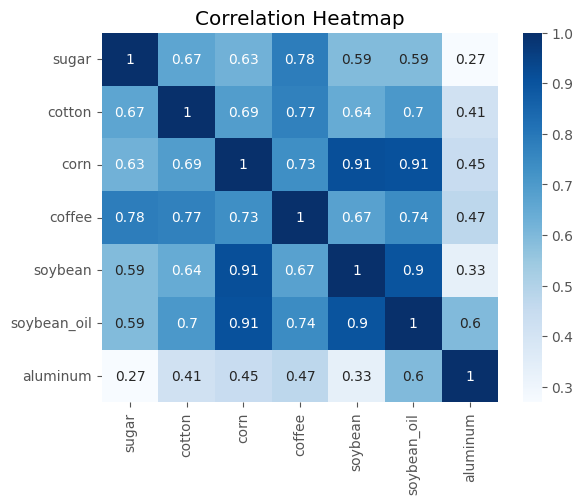

In [15]:
#Correlation heatmap
corr = all_prices.corr()

# Create heatmap
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title(f'Correlation Heatmap')

### Setting up for comparison <a id="sec3.2"></a>

I wanted to see how the price fluctuations compare to each other. Because the prices are all very different, I chose percentage of change to compare the fluctuations in price across all commodities.

In [16]:
#Percent change of all comoditiees for all three comodities for later comparison
all_prices_percent_change = all_prices.pct_change()
all_prices_percent_change_M = all_prices_M.pct_change()
all_prices_percent_change_Y = all_prices_Y.pct_change()

### Prices combined Summaries <a id="sec3.3"></a>


In [17]:
#Daily
all_prices.head()

sugar  cotton    corn  coffee  soybean  soybean_oil  aluminum
2002-10-23  0.0710  0.4521  2.5025  0.6430   5.5450       0.2084    1326.0
2002-10-25  0.0699  0.4663  2.5025  0.6855   5.5700       0.2119    1338.0
2002-10-28  0.0713  0.4631  2.4750  0.6470   5.4565       0.2087    1348.0
2002-10-29  0.0727  0.4622  2.4900  0.6290   5.5790       0.2181    1333.0
2002-10-30  0.0718  0.4610  2.4600  0.6300   5.5775       0.2168    1336.0

In [18]:
all_prices.tail()

sugar  cotton    corn  coffee  soybean  soybean_oil  aluminum
2022-06-24  0.1837  1.0376  7.5025  2.2660  16.1075       0.6975   2455.85
2022-06-27  0.1829  0.9994  7.4970  2.2680  16.0849       0.7023   2474.77
2022-06-28  0.1826  1.0196  7.4406  2.2478  16.3152       0.7085   2490.85
2022-06-29  0.1848  1.0295  7.5882  2.2279  16.6662       0.7074   2470.85
2022-06-30  0.1855  1.0492  7.6969  2.3280  16.7046       0.7012   2431.33

In [19]:
all_prices.describe()

sugar       cotton         corn       coffee      soybean  \
count  4681.000000  4681.000000  4681.000000  4681.000000  4681.000000   
mean      0.153625     0.741851     4.238816     1.369563    10.328070   
std       0.054323     0.249296     1.518258     0.459407     2.948649   
min       0.054000     0.391400     1.907500     0.560500     5.012500   
25%       0.116300     0.587800     3.455000     1.094500     8.637500   
50%       0.146100     0.690600     3.780000     1.257100     9.835000   
75%       0.184600     0.827100     5.235000     1.523500    12.825000   
max       0.353100     2.141400     8.312500     3.061500    17.690000   

       soybean_oil     aluminum  
count  4681.000000  4681.000000  
mean      0.379300  2060.932749  
std       0.128631   442.617220  
min       0.189400  1288.000000  
25%       0.288300  1763.850000  
50%       0.336900  1951.000000  
75%       0.475500  2365.000000  
max       0.882000  3849.000000

In [20]:
#Monthly
all_prices_M.head()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2002-10-31  0.071717  0.461200  2.484167  0.649000  5.565083     0.213717   
2002-11-30  0.073406  0.481375  2.427437  0.664056  5.697813     0.222244   
2002-12-31  0.074810  0.503860  2.385750  0.629300  5.643600     0.216480   
2003-01-31  0.078794  0.510139  2.352083  0.649583  5.641944     0.205850   
2003-02-28  0.087317  0.517767  2.363778  0.628133  5.701806     0.204706   

               aluminum  
2002-10-31  1338.166667  
2002-11-30  1378.000000  
2002-12-31  1376.800000  
2003-01-31  1379.833333  
2003-02-28  1409.333333

In [21]:
all_prices_M.tail()

sugar    cotton      corn    coffee    soybean  soybean_oil  \
2022-02-28  0.181650  1.239125  6.500600  2.460945  15.885375     0.670290   
2022-03-31  0.191078  1.253026  7.465652  2.228587  16.733152     0.740065   
2022-04-30  0.196332  1.395416  7.842658  2.256816  16.778526     0.787295   
2022-05-31  0.192860  1.449710  7.828875  2.181675  16.590250     0.810505   
2022-06-30  0.187100  1.321185  7.629135  2.304260  16.850170     0.754965   

               aluminum  
2022-02-28  3213.762500  
2022-03-31  3509.552174  
2022-04-30  3266.242105  
2022-05-31  2860.063500  
2022-06-30  2582.123500

In [22]:
all_prices_M.describe()

sugar      cotton        corn      coffee     soybean  \
count  237.000000  237.000000  237.000000  237.000000  237.000000   
mean     0.150682    0.736104    4.175614    1.346301   10.204920   
std      0.055502    0.247763    1.524504    0.465912    2.972430   
min      0.055880    0.423111    1.944275    0.590656    5.272344   
25%      0.115080    0.581089    3.321818    1.076543    8.562476   
50%      0.142877    0.691868    3.755684    1.248211    9.760955   
75%      0.182411    0.819568    5.153947    1.503632   12.815000   
max      0.320916    2.006878    8.038773    2.807953   16.850170   

       soybean_oil     aluminum  
count   237.000000   237.000000  
mean      0.374718  2044.782723  
std       0.128677   442.351181  
min       0.197794  1338.166667  
25%       0.284026  1746.595238  
50%       0.332768  1933.388889  
75%       0.466889  2335.523684  
max       0.810505  3509.552174

In [23]:
#Yearly
all_prices_Y.head()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2002-12-31  0.073528  0.484619  2.425047  0.650372  5.655984     0.218844   
2003-12-31  0.070143  0.598642  2.335328  0.624503  6.296221     0.226000   
2004-12-31  0.075558  0.545429  2.496232  0.774228  7.267136     0.261391   
2005-12-31  0.100474  0.507222  2.118782  1.079012  6.136122     0.227066   
2006-12-31  0.146364  0.523831  2.625165  1.083871  5.945710     0.251239   

               aluminum  
2002-12-31  1370.156250  
2003-12-31  1425.805970  
2004-12-31  1728.165563  
2005-12-31  1902.215556  
2006-12-31  2597.398041

In [24]:
all_prices_Y.tail()

sugar    cotton      corn    coffee    soybean  soybean_oil  \
2018-12-31  0.122719  0.820701  3.700973  1.136432   9.337805     0.299246   
2019-12-31  0.123575  0.673787  3.857450  1.017841   8.932635     0.293129   
2020-12-31  0.128944  0.643035  3.640972  1.111682   9.535121     0.312803   
2021-12-31  0.178912  0.934919  5.742911  1.693772  13.684052     0.577515   
2022-12-31  0.188943  1.307972  7.238638  2.298261  16.179177     0.729480   

               aluminum  
2018-12-31  2113.245902  
2019-12-31  1812.916452  
2020-12-31  1731.591492  
2021-12-31  2489.281653  
2022-12-31  3082.201074

In [25]:
all_prices_Y.describe()

sugar     cotton       corn     coffee    soybean  soybean_oil  \
count  21.000000  21.000000  21.000000  21.000000  21.000000    21.000000   
mean    0.148914   0.739734   4.182742   1.344488  10.172620     0.377281   
std     0.052455   0.236596   1.540538   0.478936   3.031101     0.136123   
min     0.070143   0.484619   2.118782   0.624503   5.655984     0.218844   
25%     0.121284   0.575703   3.596669   1.083871   8.650238     0.293129   
50%     0.146364   0.656322   3.757141   1.262322   9.785745     0.334154   
75%     0.179519   0.820701   5.297314   1.636942  12.323684     0.458677   
max     0.270685   1.356376   7.238638   2.527503  16.179177     0.729480   

          aluminum  
count    21.000000  
mean   2045.969347  
std     450.811774  
min    1370.156250  
25%    1728.165563  
50%    1902.215556  
75%    2420.197959  
max    3082.201074

### Percent Change Summaries <a id="sec3.4"></a>

In [26]:
#Daily
all_prices_percent_change.head()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2002-10-23       NaN       NaN       NaN       NaN       NaN          NaN   
2002-10-25 -0.015493  0.031409  0.000000  0.066096  0.004509     0.016795   
2002-10-28  0.020029 -0.006863 -0.010989 -0.056163 -0.020377    -0.015101   
2002-10-29  0.019635 -0.001943  0.006061 -0.027821  0.022450     0.045041   
2002-10-30 -0.012380 -0.002596 -0.012048  0.001590 -0.000269    -0.005961   

            aluminum  
2002-10-23       NaN  
2002-10-25  0.009050  
2002-10-28  0.007474  
2002-10-29 -0.011128  
2002-10-30  0.002251

In [27]:
all_prices_percent_change.tail()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2022-06-24 -0.000544 -0.238850  0.004687 -0.025167  0.010984     0.030128   
2022-06-27 -0.004355 -0.036816 -0.000733  0.000883 -0.001403     0.006882   
2022-06-28 -0.001640  0.020212 -0.007523 -0.008907  0.014318     0.008828   
2022-06-29  0.012048  0.009710  0.019837 -0.008853  0.021514    -0.001553   
2022-06-30  0.003788  0.019136  0.014325  0.044930  0.002304    -0.008764   

            aluminum  
2022-06-24 -0.008679  
2022-06-27  0.007704  
2022-06-28  0.006498  
2022-06-29 -0.008029  
2022-06-30 -0.015994

In [28]:
all_prices_percent_change.describe()

sugar       cotton         corn       coffee      soybean  \
count  4680.000000  4680.000000  4680.000000  4680.000000  4680.000000   
mean      0.000413     0.000348     0.000398     0.000488     0.000356   
std       0.020373     0.018245     0.017797     0.020698     0.015475   
min      -0.116318    -0.238850    -0.078749    -0.106439    -0.099350   
25%      -0.011159    -0.008980    -0.009246    -0.011819    -0.007661   
50%       0.000000     0.000170     0.000000     0.000363     0.000793   
75%       0.011767     0.009943     0.010025     0.011791     0.008562   
max       0.110230     0.123173     0.094257     0.138509     0.087185   

       soybean_oil     aluminum  
count  4680.000000  4680.000000  
mean      0.000381     0.000224  
std       0.015590     0.013698  
min      -0.088610    -0.080695  
25%      -0.008697    -0.007545  
50%       0.000000     0.000088  
75%       0.009539     0.008191  
max       0.084023     0.061368

In [29]:
#Monthly
all_prices_percent_change_M.head()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2002-10-31       NaN       NaN       NaN       NaN       NaN          NaN   
2002-11-30  0.023559  0.043745 -0.022836  0.023199  0.023850     0.039899   
2002-12-31  0.019123  0.046710 -0.017173 -0.052339 -0.009515    -0.025934   
2003-01-31  0.053261  0.012462 -0.014112  0.032232 -0.000293    -0.049104   
2003-02-28  0.108158  0.014952  0.004972 -0.033021  0.010610    -0.005560   

            aluminum  
2002-10-31       NaN  
2002-11-30  0.029767  
2002-12-31 -0.000871  
2003-01-31  0.002203  
2003-02-28  0.021379

In [30]:
all_prices_percent_change_M.tail()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2022-02-28 -0.015251  0.035707  0.064914  0.038719  0.128265     0.100564   
2022-03-31  0.051903  0.011218  0.148456 -0.094418  0.053368     0.104097   
2022-04-30  0.027493  0.113637  0.050499  0.012667  0.002712     0.063818   
2022-05-31 -0.017682  0.038909 -0.001757 -0.033295 -0.011221     0.029481   
2022-06-30 -0.029866 -0.088656 -0.025513  0.056188  0.015667    -0.068525   

            aluminum  
2022-02-28  0.070333  
2022-03-31  0.092038  
2022-04-30 -0.069328  
2022-05-31 -0.124357  
2022-06-30 -0.097180

In [31]:
all_prices_percent_change_M.describe()

sugar      cotton        corn      coffee     soybean  \
count  236.000000  236.000000  236.000000  236.000000  236.000000   
mean     0.007269    0.006867    0.007230    0.007682    0.006557   
std      0.080502    0.068661    0.070095    0.069028    0.060832   
min     -0.277513   -0.300790   -0.244695   -0.165160   -0.214738   
25%     -0.042955   -0.033991   -0.028200   -0.039338   -0.026117   
50%      0.004042    0.007121    0.007917    0.001954    0.002955   
75%      0.052839    0.047522    0.047916    0.050387    0.038898   
max      0.242327    0.211873    0.258090    0.311268    0.169568   

       soybean_oil    aluminum  
count   236.000000  236.000000  
mean      0.007021    0.004031  
std       0.057749    0.049564  
min      -0.222666   -0.193013  
25%      -0.029516   -0.026711  
50%       0.005719    0.007474  
75%       0.043294    0.035483  
max       0.152107    0.151857

In [32]:
#Yearly
all_prices_percent_change_Y.head()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2002-12-31       NaN       NaN       NaN       NaN       NaN          NaN   
2003-12-31 -0.046041  0.235284 -0.036997 -0.039775  0.113196     0.032698   
2004-12-31  0.077197 -0.088889  0.068900  0.239749  0.154206     0.156602   
2005-12-31  0.329771 -0.070050 -0.151208  0.393663 -0.155634    -0.131319   
2006-12-31  0.456731  0.032745  0.238997  0.004503 -0.031031     0.106460   

            aluminum  
2002-12-31       NaN  
2003-12-31  0.040616  
2004-12-31  0.212062  
2005-12-31  0.100714  
2006-12-31  0.365459

In [33]:
all_prices_percent_change_Y.tail()

sugar    cotton      corn    coffee   soybean  soybean_oil  \
2018-12-31 -0.223043  0.120739  0.023329 -0.148687 -0.045775    -0.104468   
2019-12-31  0.006970 -0.179011  0.042280 -0.104354 -0.043390    -0.020440   
2020-12-31  0.043447 -0.045639 -0.056119  0.092197  0.067448     0.067116   
2021-12-31  0.387520  0.453915  0.577302  0.523611  0.435121     0.846256   
2022-12-31  0.056068  0.399022  0.260447  0.356890  0.182338     0.263136   

            aluminum  
2018-12-31  0.067122  
2019-12-31 -0.142118  
2020-12-31 -0.044859  
2021-12-31  0.437569  
2022-12-31  0.238189

In [34]:
all_prices_percent_change_Y.describe()

sugar     cotton       corn     coffee    soybean  soybean_oil  \
count  20.000000  20.000000  20.000000  20.000000  20.000000    20.000000   
mean    0.076294   0.078802   0.084022   0.095009   0.070922     0.090559   
std     0.250358   0.252986   0.257902   0.261241   0.200115     0.269170   
min    -0.323425  -0.410822  -0.292316  -0.305560  -0.231611    -0.305041   
25%    -0.146857  -0.089354  -0.064508  -0.064813  -0.047471    -0.109252   
50%     0.049758   0.040866   0.022142   0.058539   0.037467     0.049907   
75%     0.258589   0.149375   0.244360   0.315569   0.161239     0.197779   
max     0.480152   0.632384   0.579747   0.544040   0.454870     0.846256   

        aluminum  
count  20.000000  
mean    0.058596  
std     0.193479  
min    -0.349785  
25%    -0.053459  
50%     0.033112  
75%     0.216381  
max     0.437569

### Take aways for me from this section

* It looks like the dataframes were properly merged; all columns are equal. They now start and end on the same date.
* We can now see the basic summary statistics both in the original pricing values and the percentage of change.


#Plots <a id="sec4"></a>

### Individual Plots <a id="sec4.1"></a>

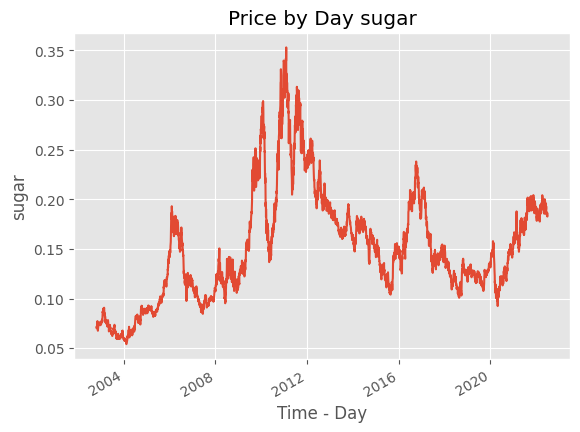

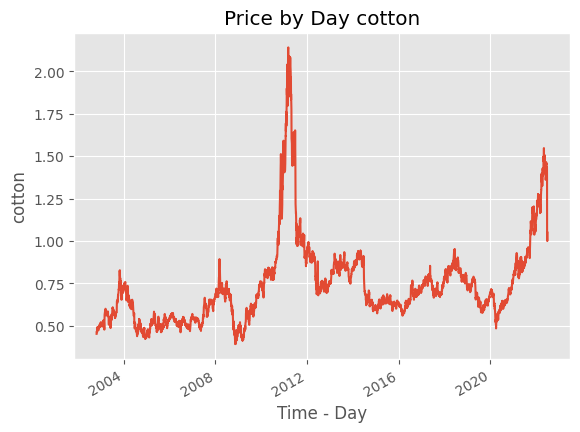

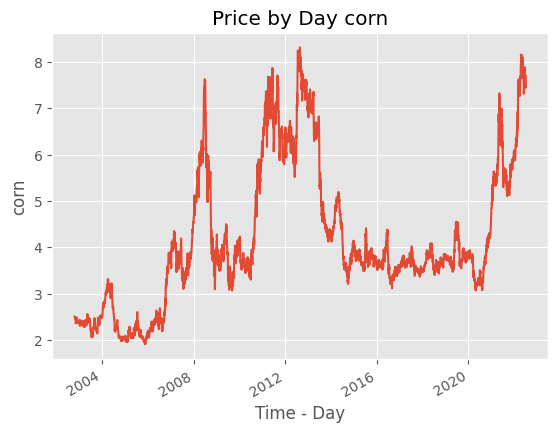

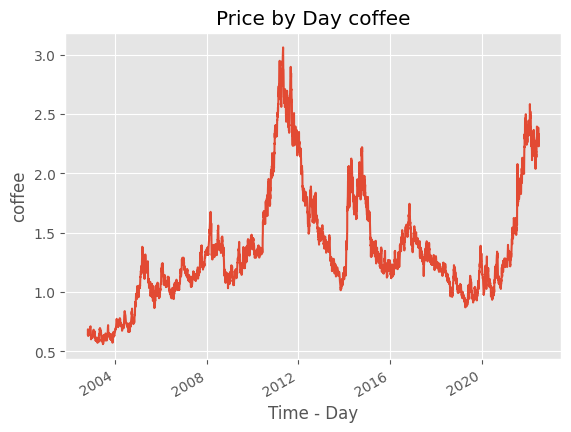

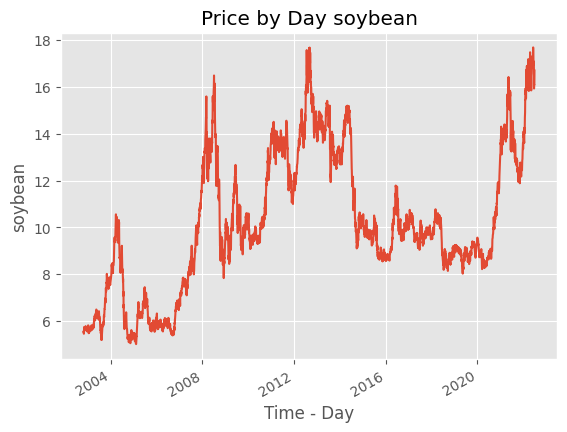

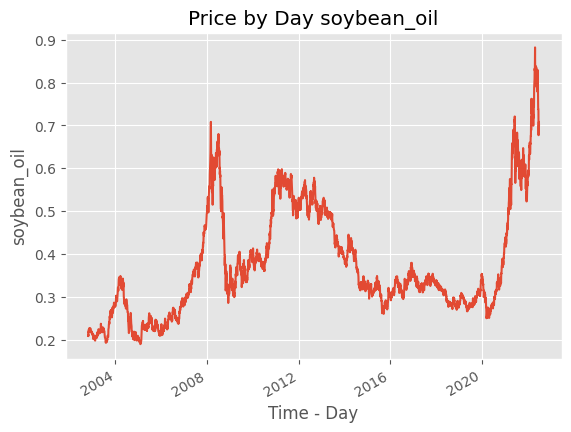

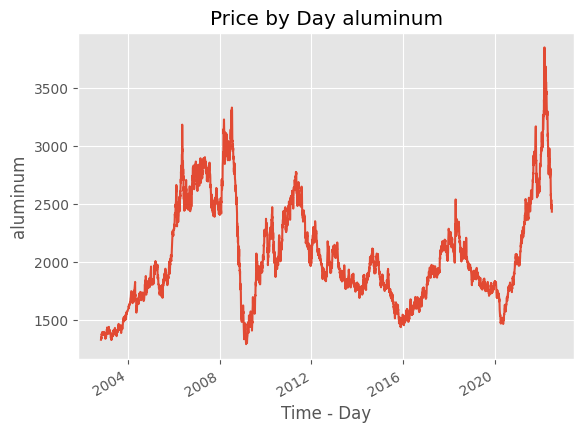

In [35]:
# Will print an inividual plot for all comodities by day
for col in all_prices.columns:
  all_prices[col].plot()
  plt.title(f'Price by Day {col}')
  plt.xlabel('Time - Day')
  plt.ylabel(f'{col}')
  plt.show()

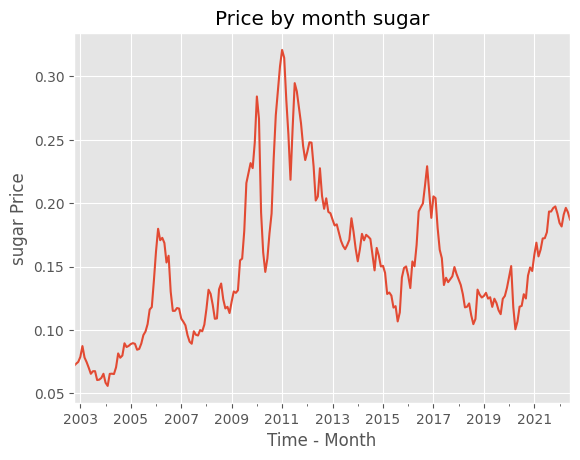

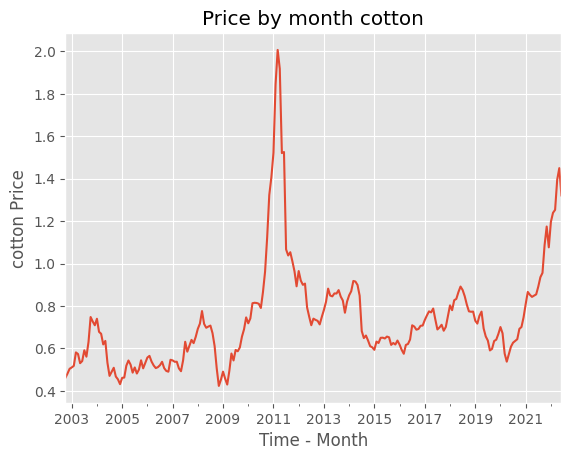

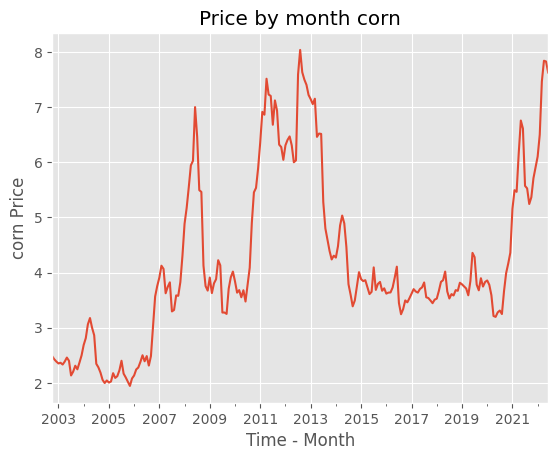

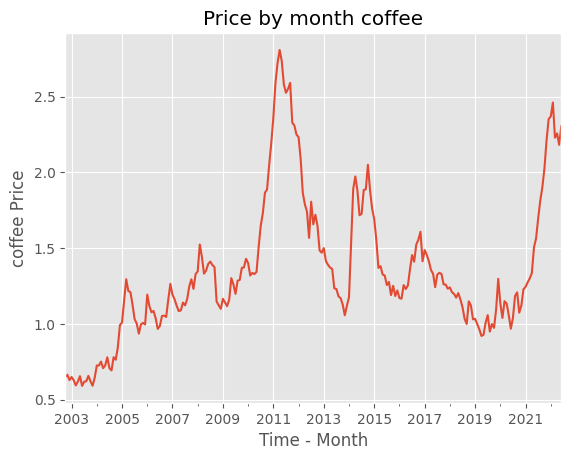

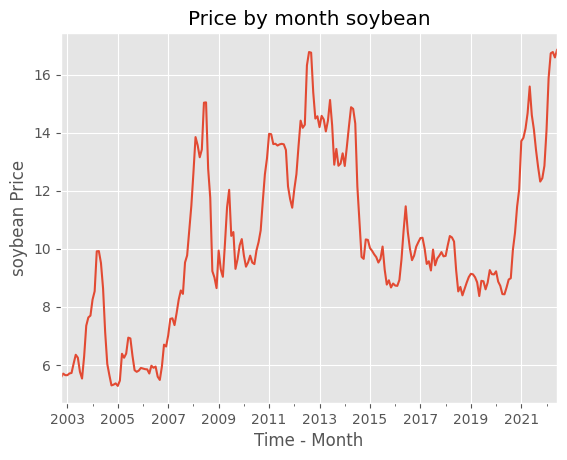

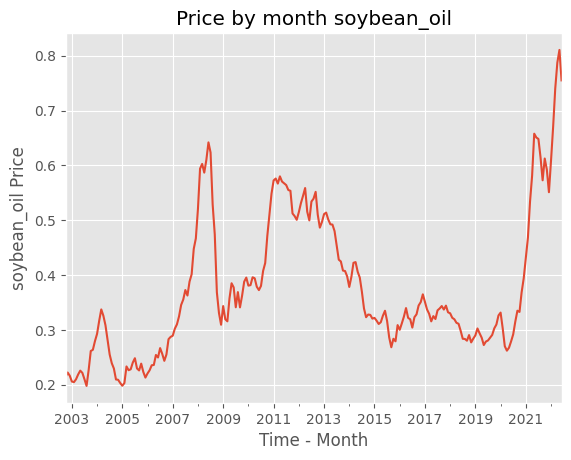

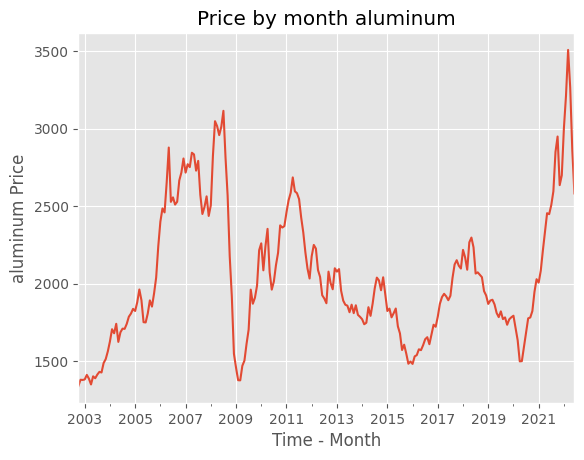

In [36]:
# Will print an inividual plot for all comodities by month
for col in all_prices_M.columns:
  all_prices_M[col].plot()
  plt.title(f'Price by month {col}')
  plt.xlabel('Time - Month')
  plt.ylabel(f'{col} Price')
  plt.show()

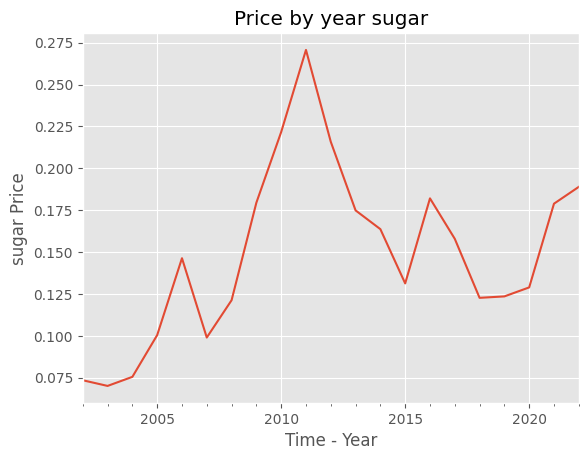

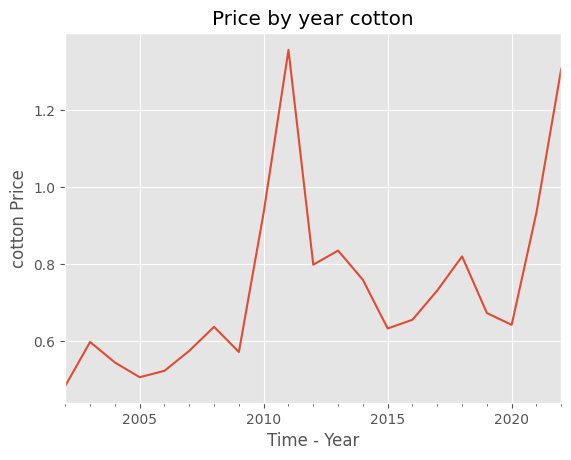

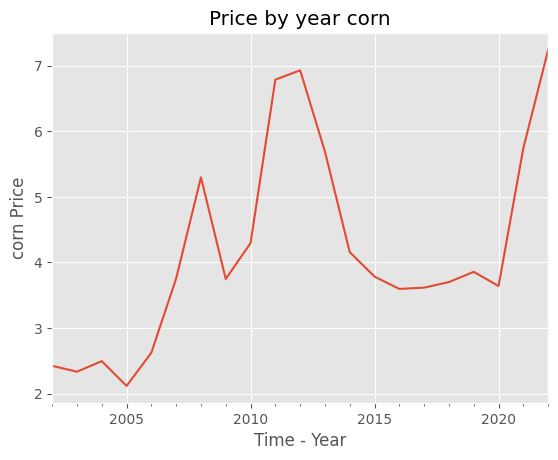

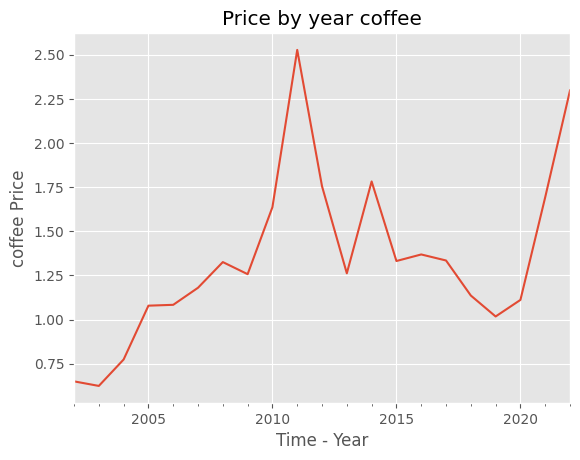

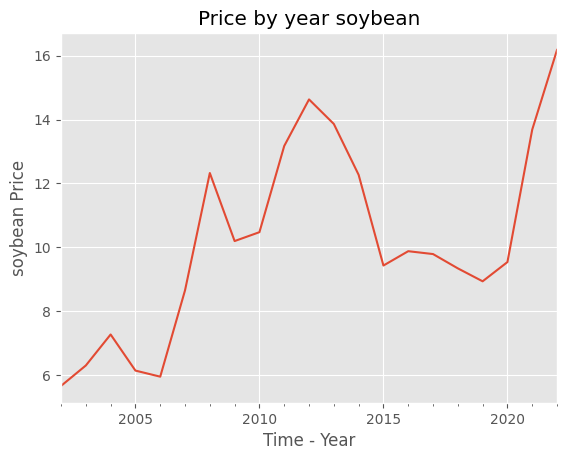

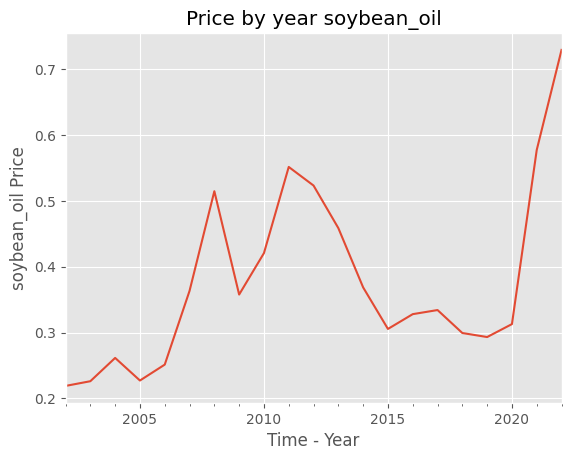

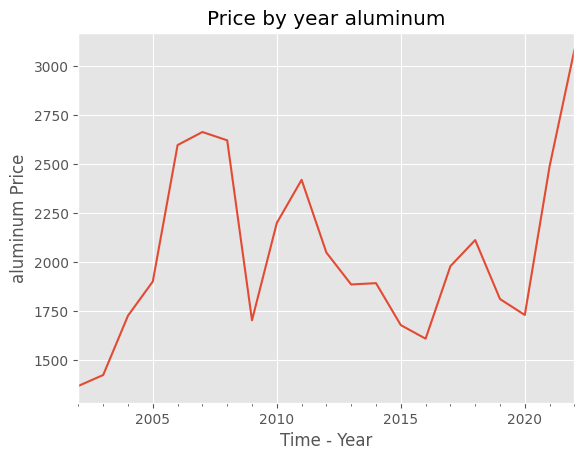

In [37]:
# Will print an inividual plot for all comodities by Year
for col in all_prices_Y.columns:
  all_prices_Y[col].plot()
  plt.title(f'Price by year {col}')
  plt.xlabel('Time - Year')
  plt.ylabel(f'{col} Price')
  plt.show()

### Takeaways from this section

You can see that there are moments in time that either have a direct or delayed reaction to major economic moments (~2008, ~2011, ~2020)
*	In 2011 cotton spiked due to extreme weather events in Pakistan(flood) and China(drought) as well as a restriction of exports in India.
*	Coffee was affected by extreme weather circumstances in 2022, 2011, 1986, and 1977.
*	Soybean oil and aluminum prices hit a historic high last year (2022). Soybeans also hit historic highs in 2021 and 2022.



### Grouped Plots <a id="sec4.2"></a>

I wanted to see how the price flucuations compare to each other. Becuase the prices are all very different, put them on the same scale of measurement

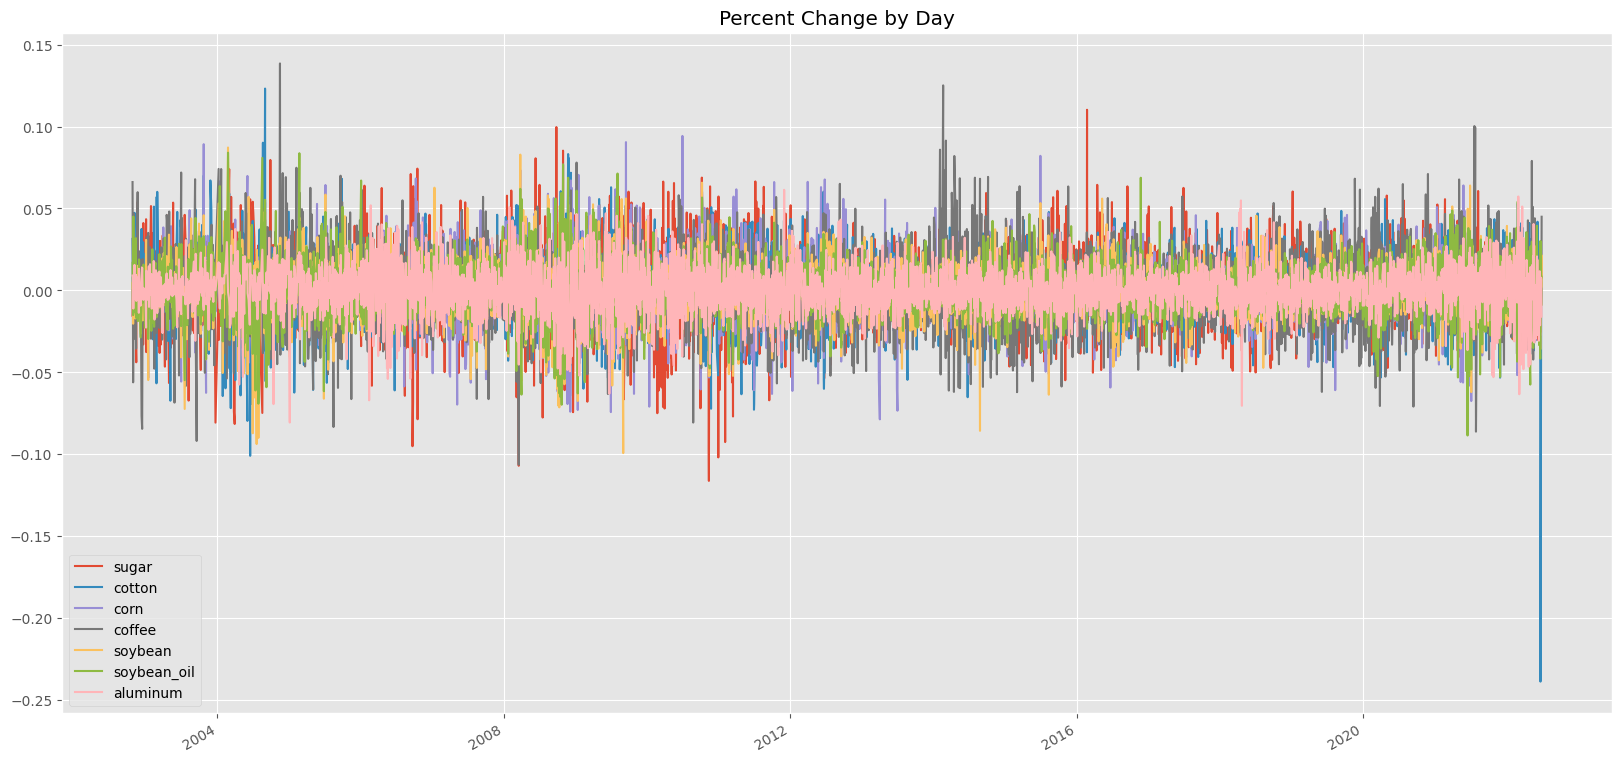

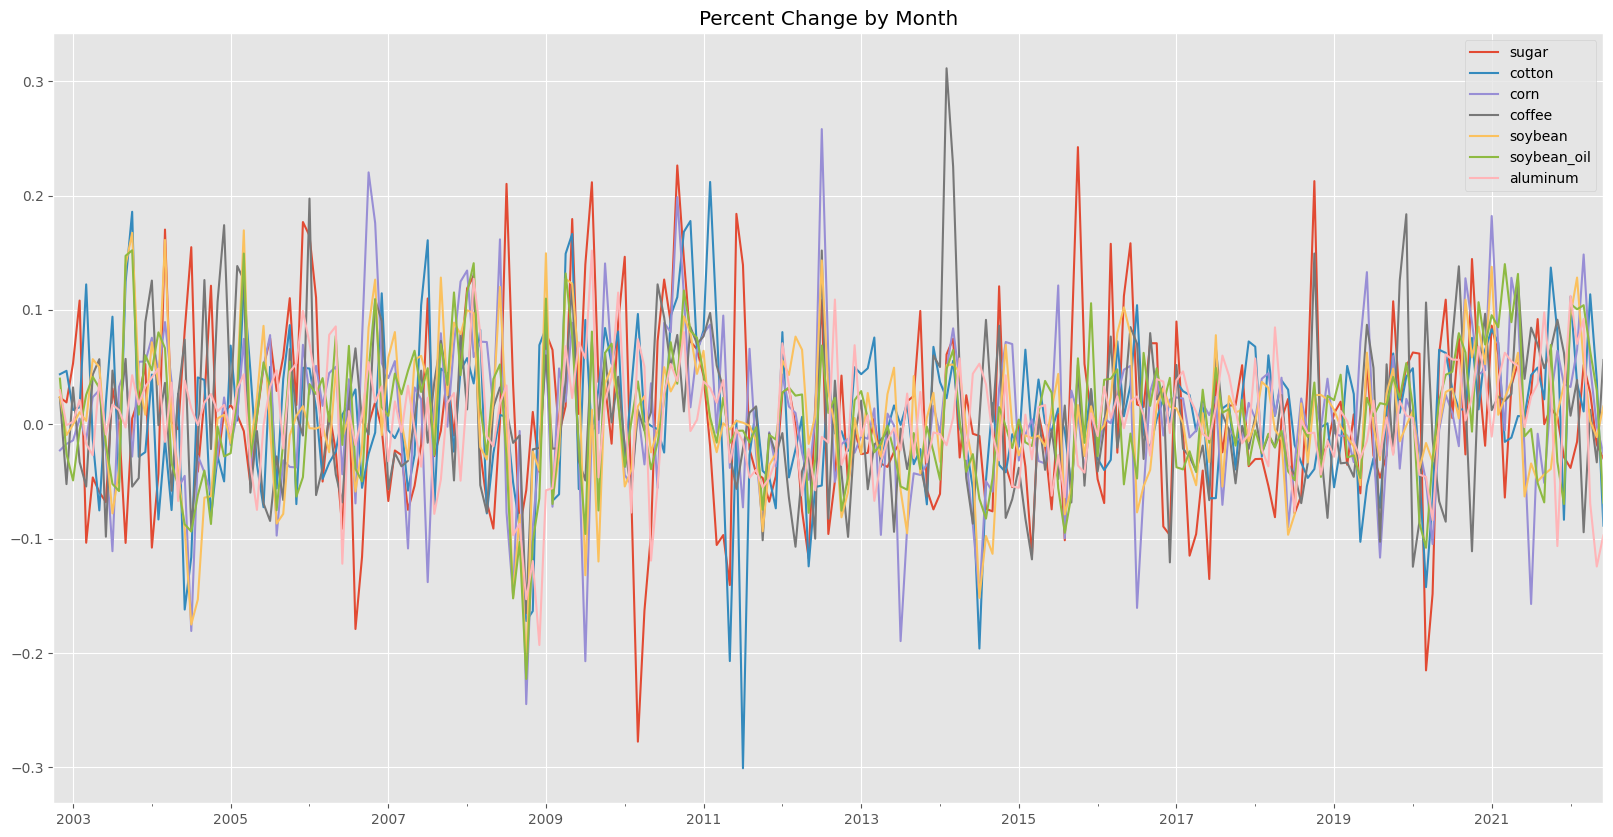

In [38]:
#All dates
all_prices_percent_change.plot(figsize=(20,10))
plt.title(f'Percent Change by Day')
plt.show()

#By month
all_prices_percent_change_M.plot(figsize=(20,10))
plt.title(f'Percent Change by Month')
plt.show()

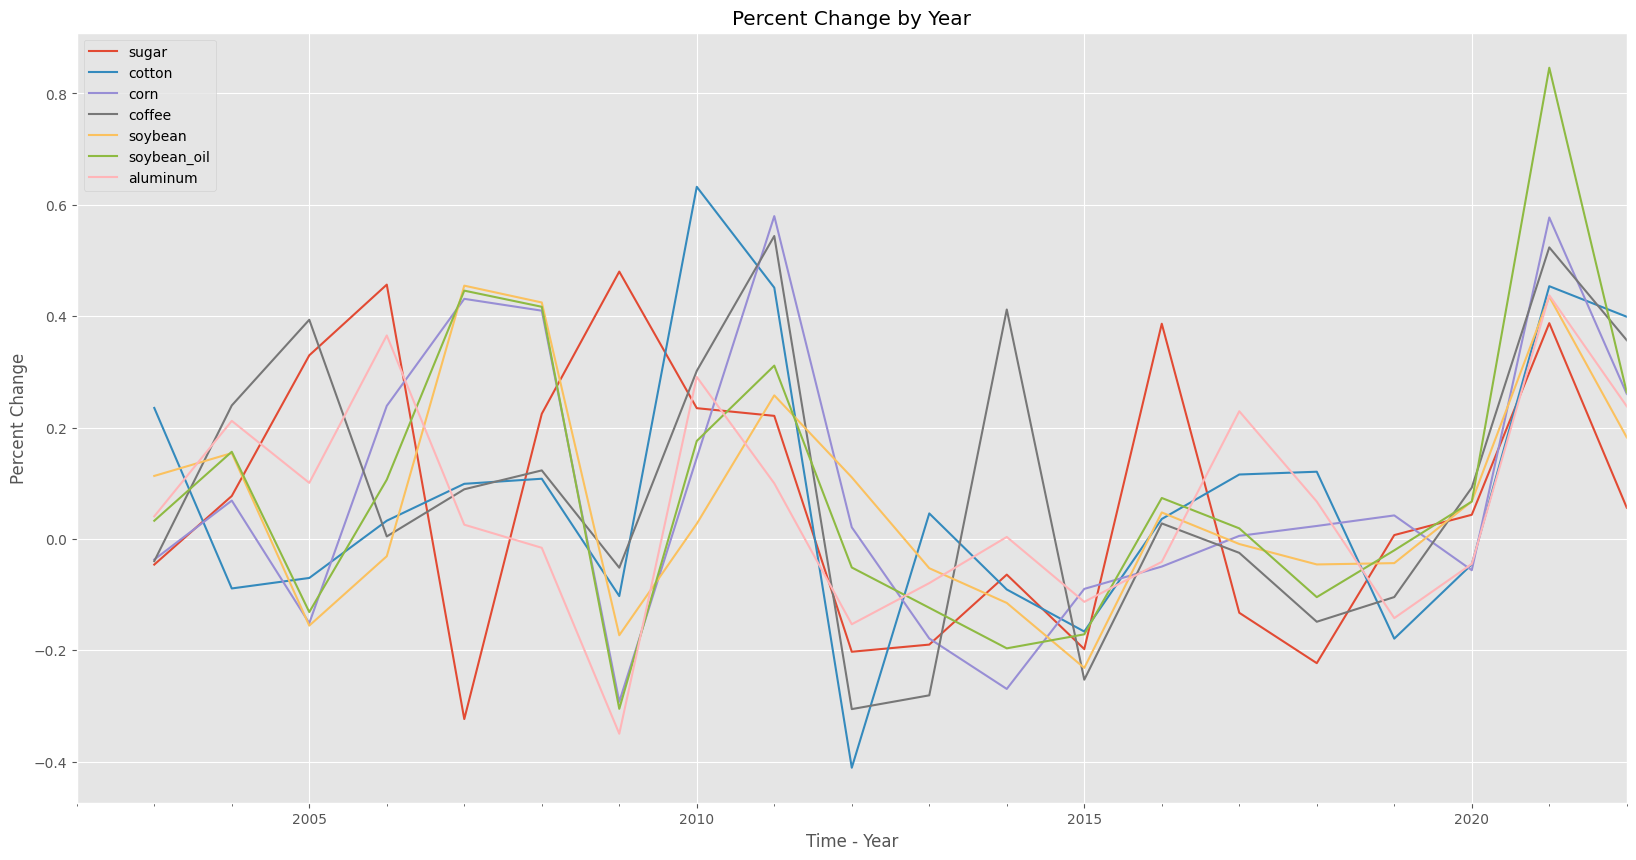

In [39]:
all_prices_percent_change_Y.plot(figsize=(20,10))
plt.title(f'Percent Change by Year')
plt.xlabel('Time - Year')
plt.ylabel('Percent Change')
plt.show()

### Take aways from this section

* I didn't learn a lot from the first two plots, there was too much overlapping information
* The yearly plot in this case is the most interesting. To see that the prices do somewhat rise and fall together. This doesn't nessesarily mean that they covary. This could be explored purther with correlation plot

### Seasonality and Trends <a id="sec4.3"></a>

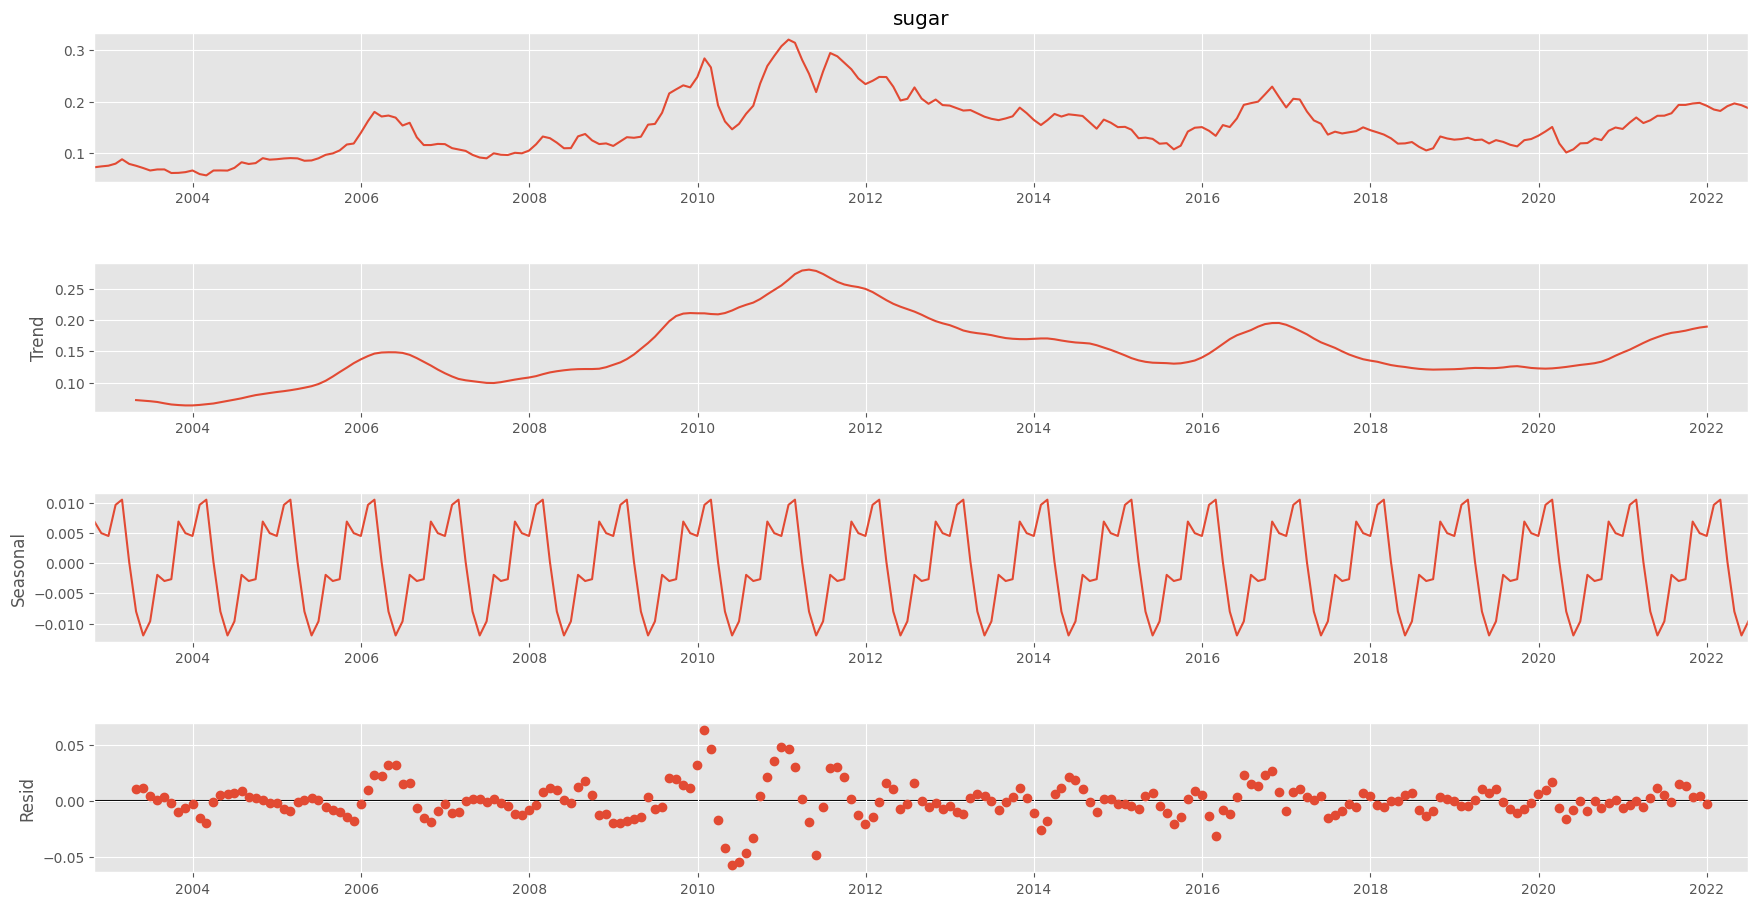

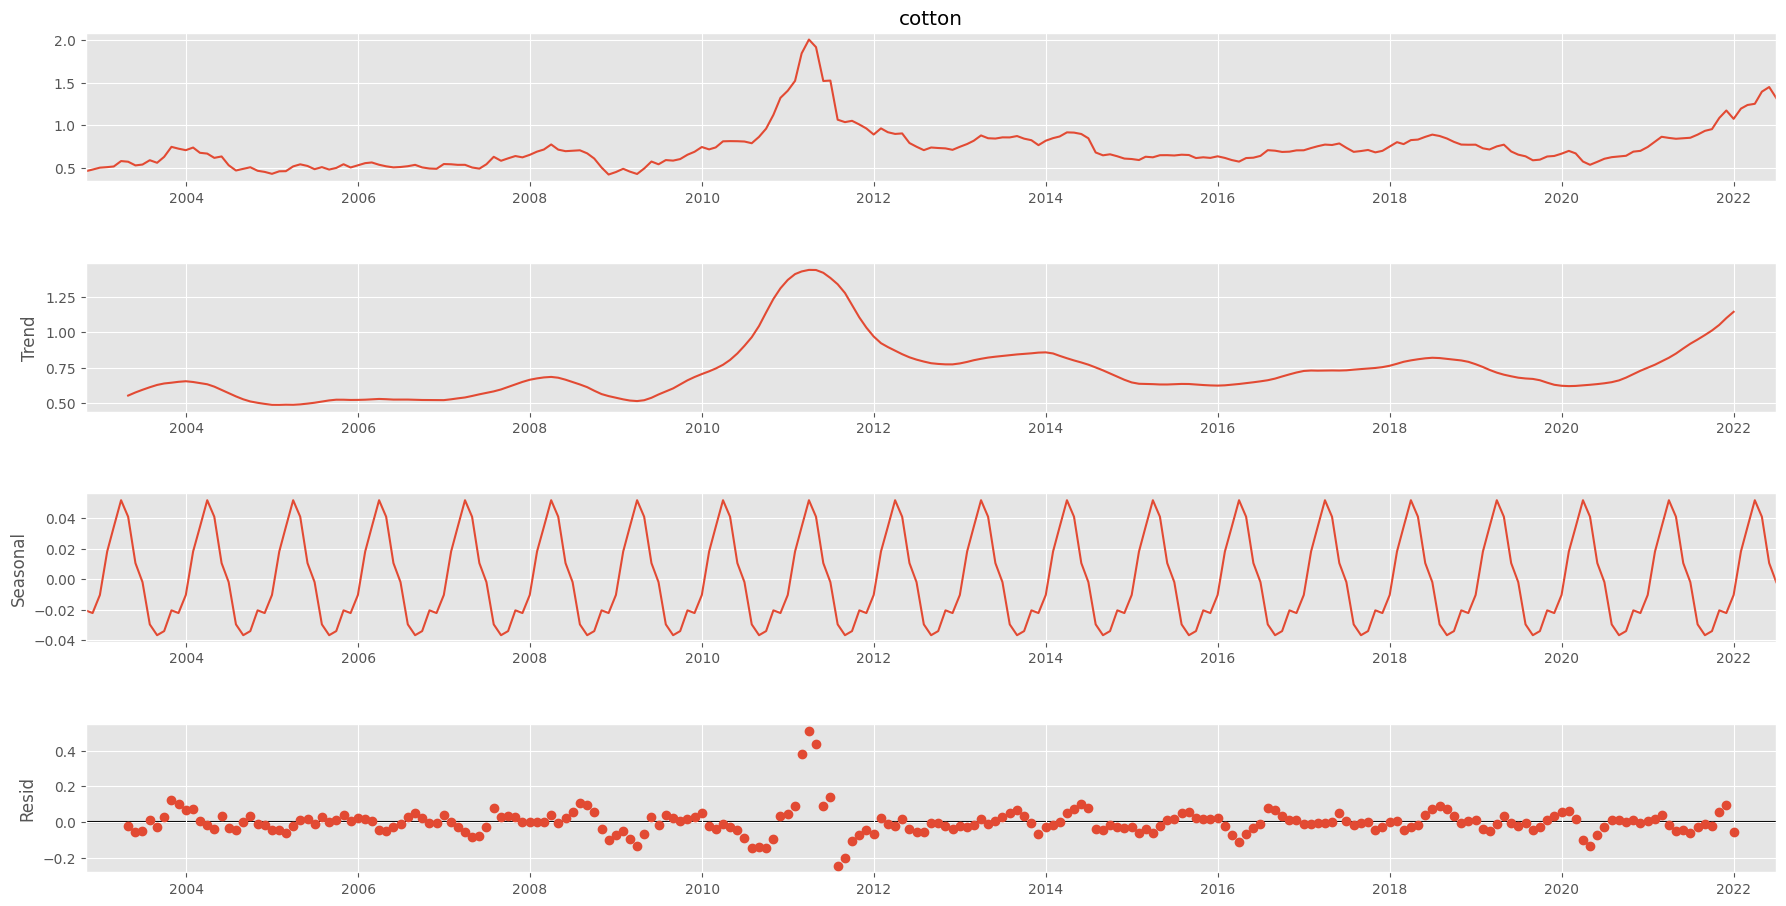

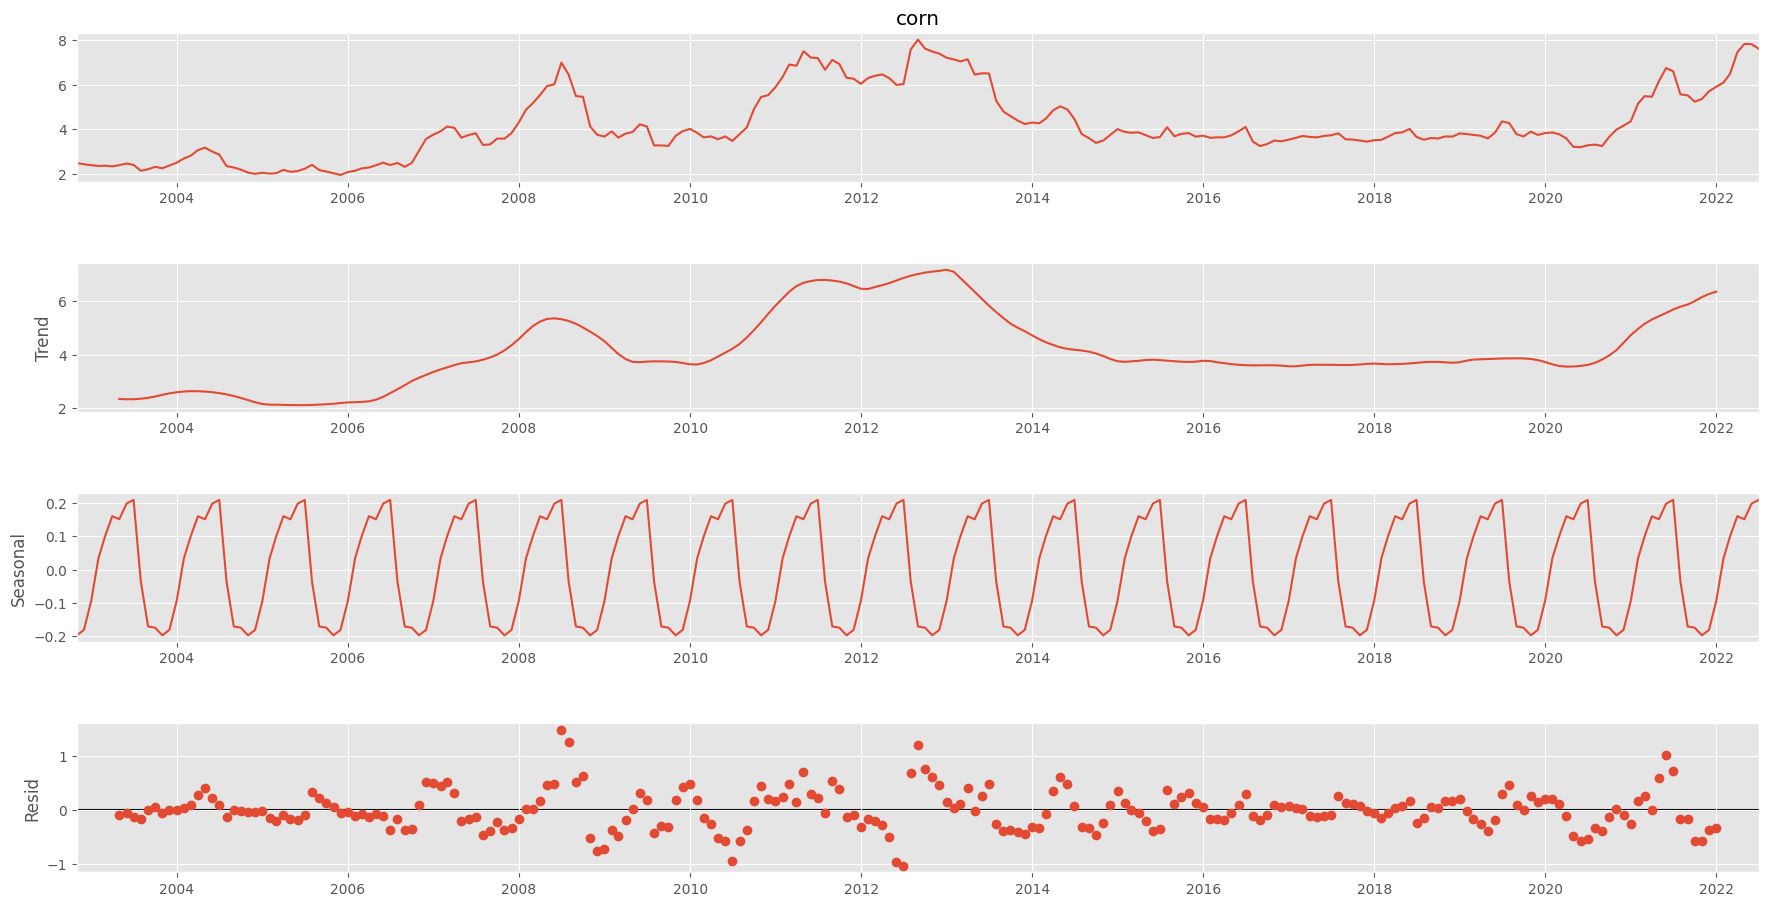

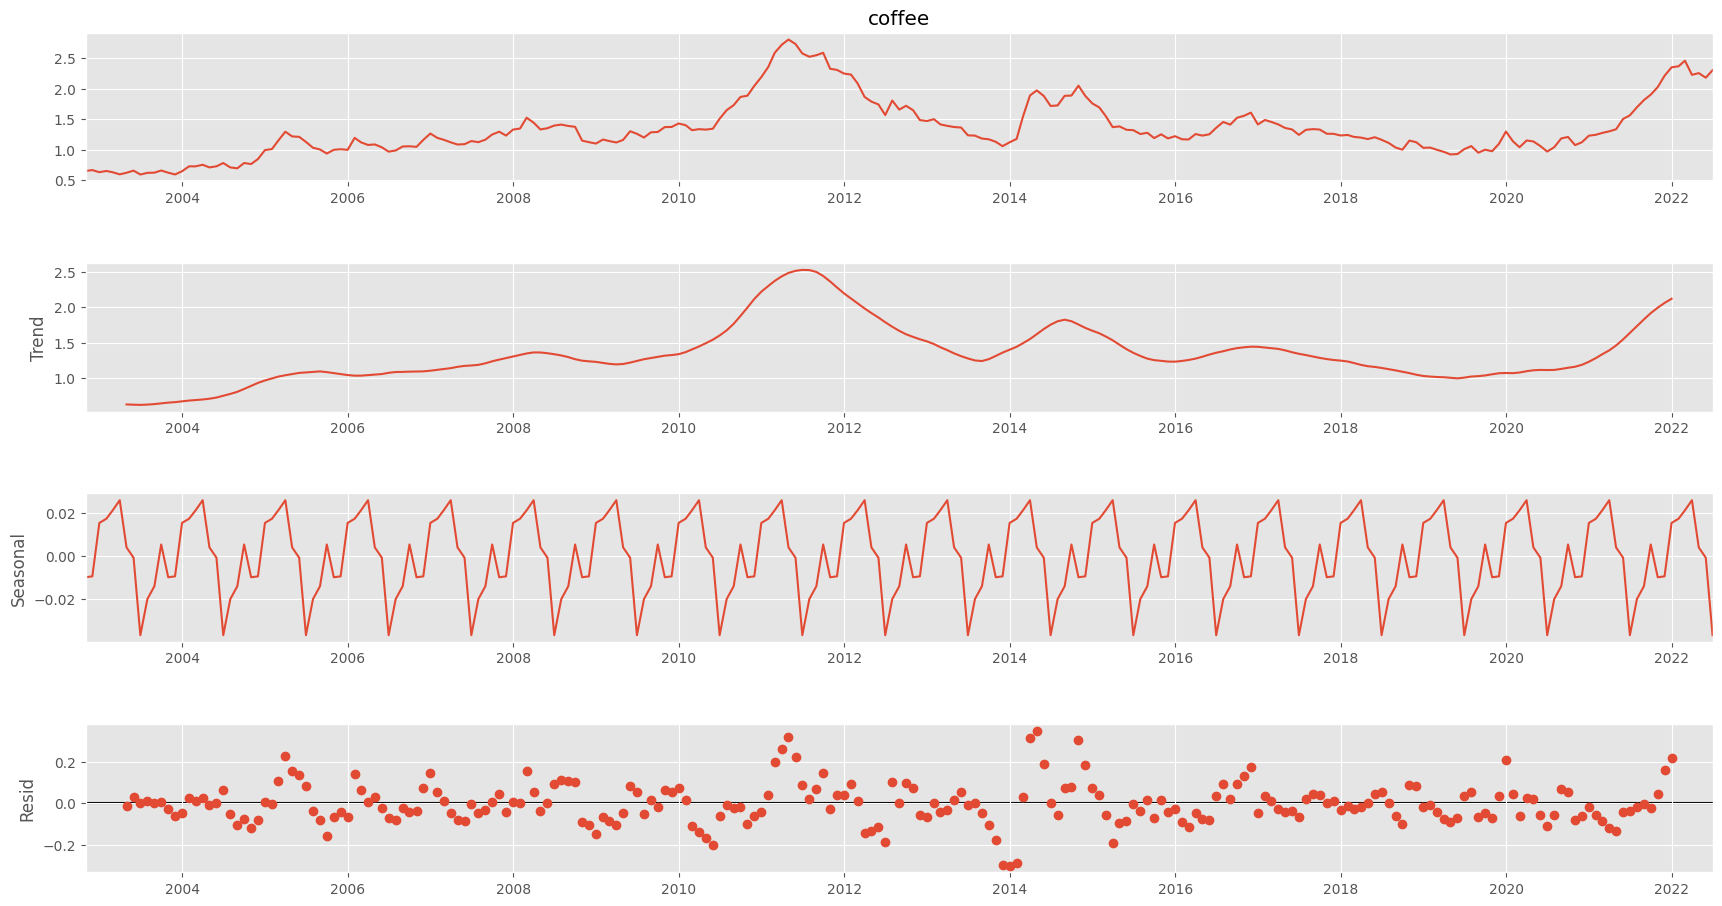

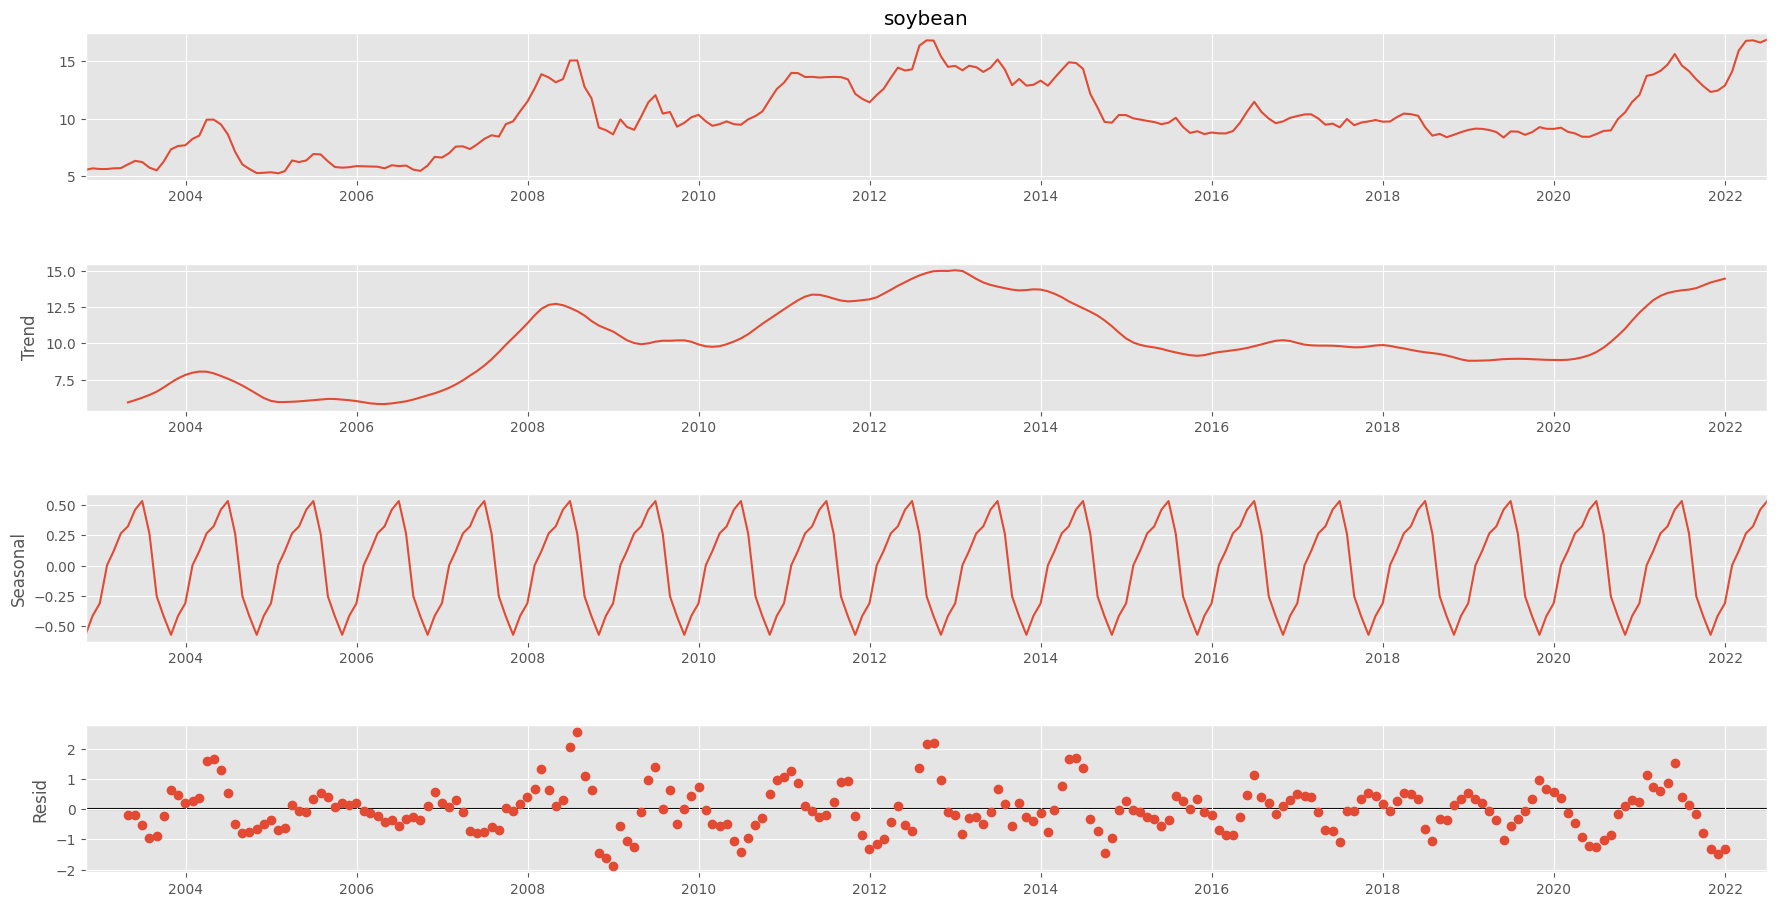

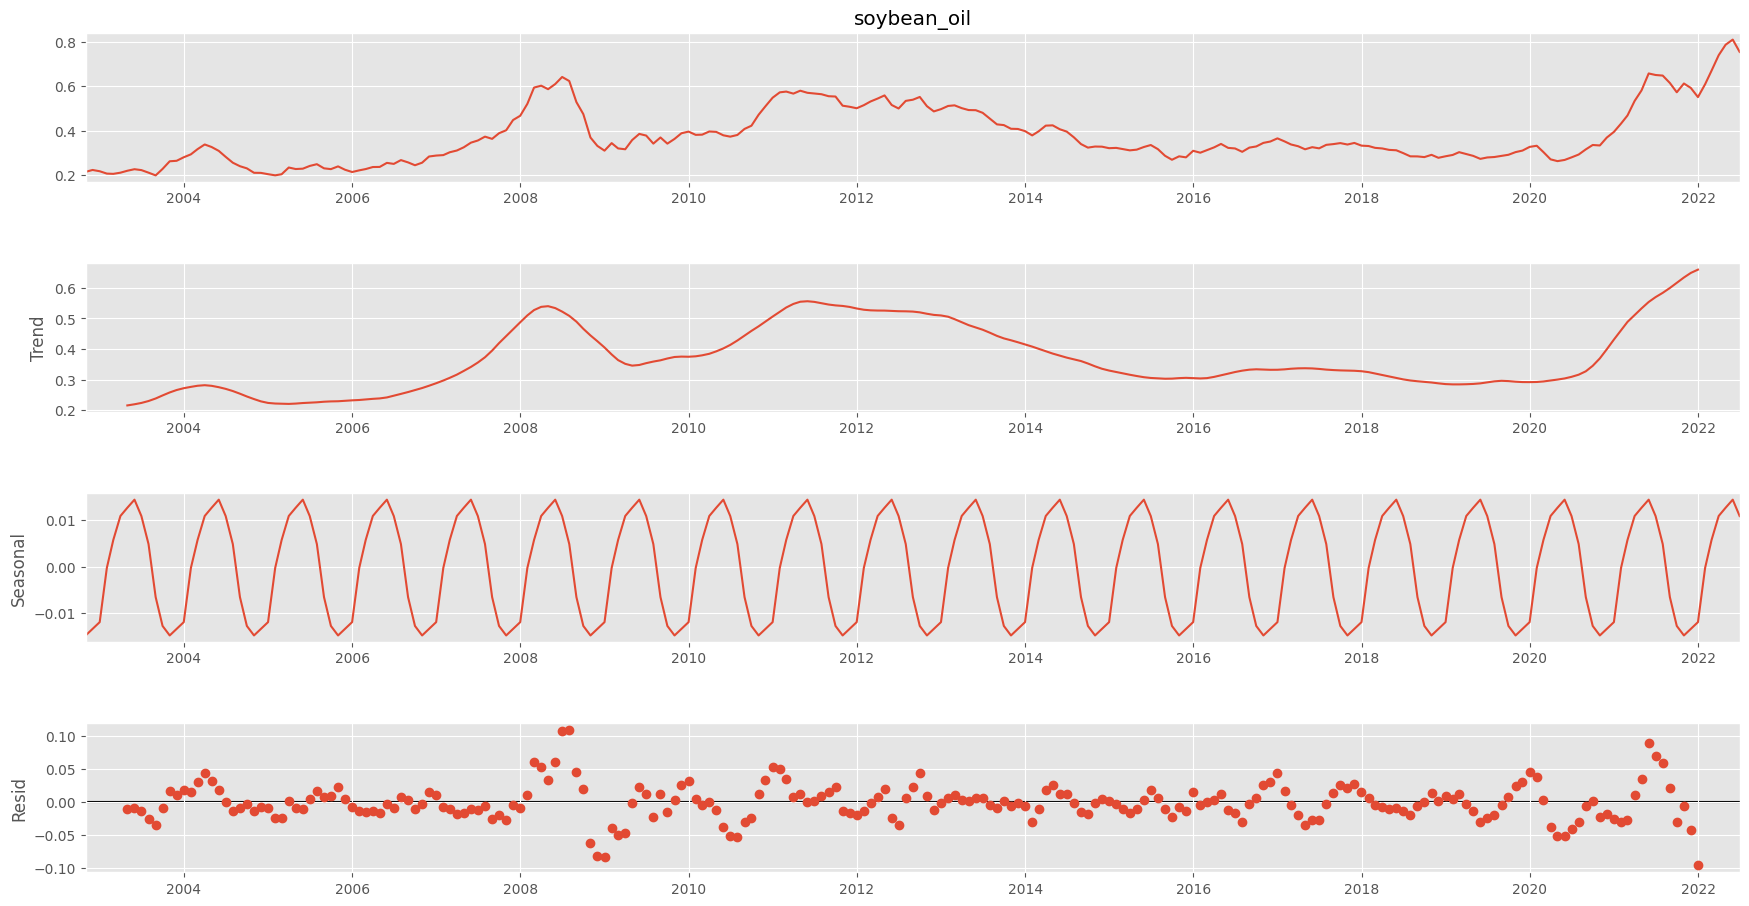

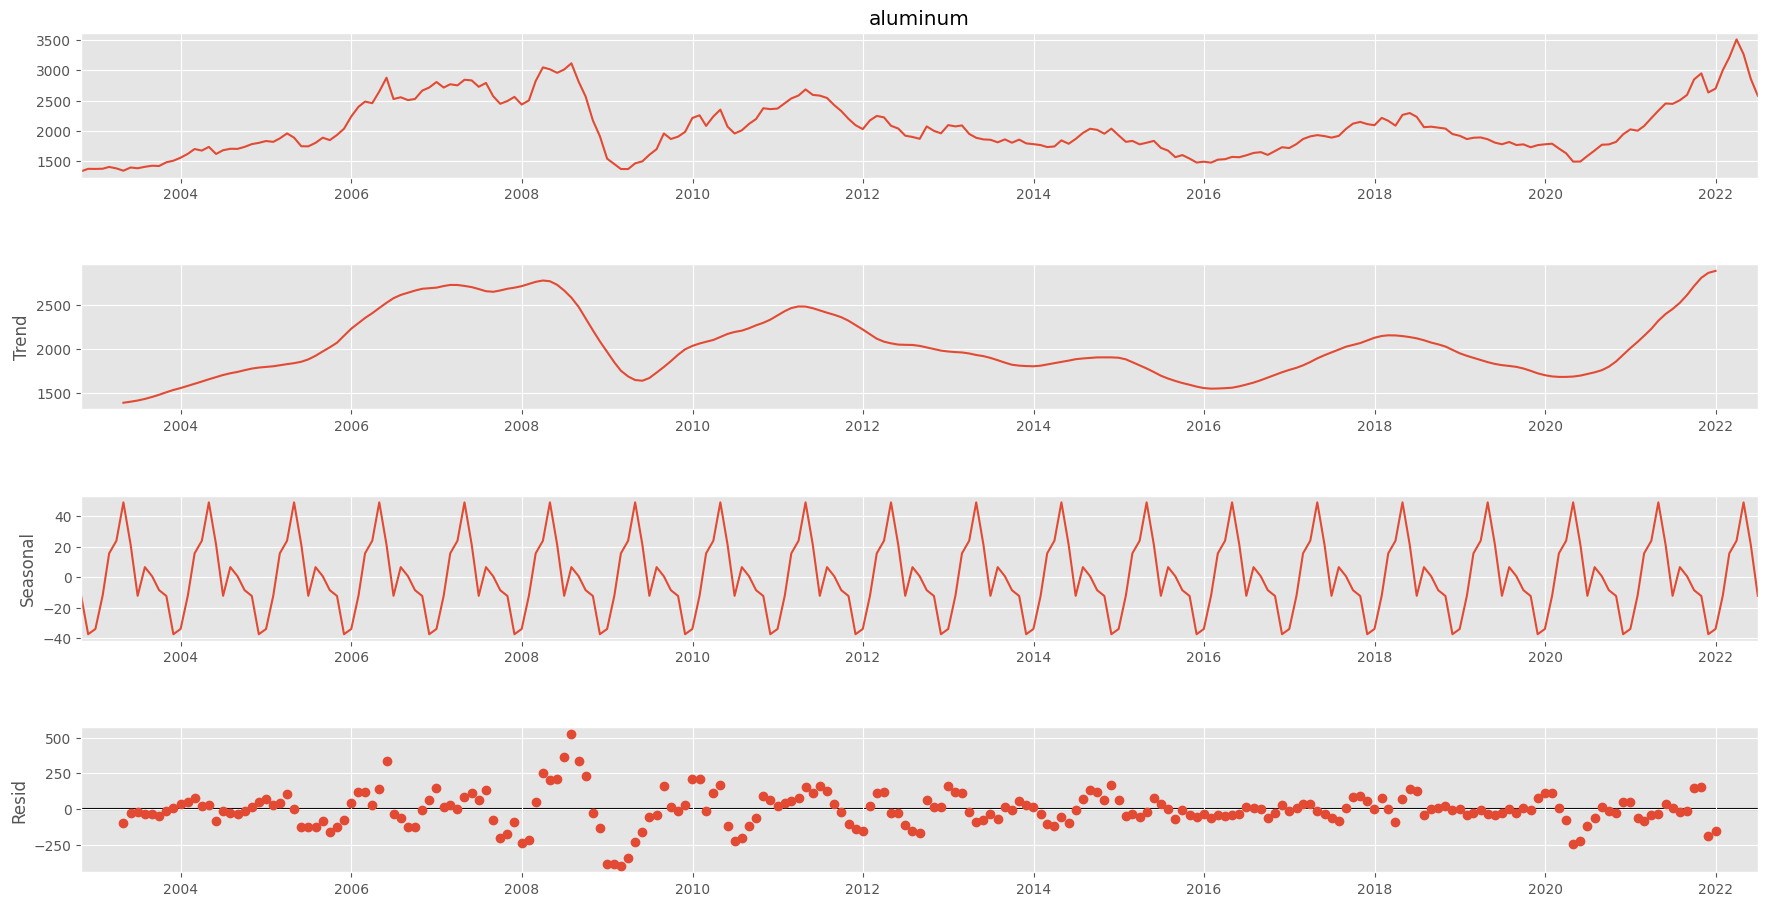

In [40]:
for col in all_prices_M.columns:
  result = seasonal_decompose(all_prices_M[col], period=12)
  result.plot().set_size_inches(20, 10)
  plt.show()

### Takeaways from this section

* These charts are ment to give you a look into your data.
* Will show any pattern of seasonality.
* These plots are interesting in that it shows the differences in the trends of each commodity.


# Modeling <a id="sec6"></a>

I would have liked to run 3 models: ARIMA, Long Short-Term Memory (LSTM), and GARCH models. These models all can make predictions for time series data. ARIMA isn't mentioned as the most effective for commodities, but it is the only model for time series forecasting that we learn in this program. I thought it would be a good comparison for more complicated models. The LSTM model is a deep learning neural network model, it is useful for long term trends in data. The GARCH model, which I did not manage to produce, is specifically applicable for forecasting commodities pricing.

##ARIMA <a id="sec6.1"></a>

##Preprocessing for ARIMA models

In [41]:
#Test and train split
x = len(all_prices_M)
size = int(x * 0.8)
index = x - size
all_prices_M_train = all_prices_M.iloc[:size,]
all_prices_M_test = all_prices_M.iloc[size:,]

In [42]:
#Checking the trian split
for col in all_prices_M_train.columns:
  col = pd.DataFrame(all_prices_M_train[col])
  print(col)
  print(len(col))

               sugar
2002-10-31  0.071717
2002-11-30  0.073406
2002-12-31  0.074810
2003-01-31  0.078794
2003-02-28  0.087317
...              ...
2018-02-28  0.135574
2018-03-31  0.128257
2018-04-30  0.117837
2018-05-31  0.118347
2018-06-30  0.120967

[189 rows x 1 columns]
189
              cotton
2002-10-31  0.461200
2002-11-30  0.481375
2002-12-31  0.503860
2003-01-31  0.510139
2003-02-28  0.517767
...              ...
2018-02-28  0.780116
2018-03-31  0.827152
2018-04-30  0.833284
2018-05-31  0.865279
2018-06-30  0.891467

[189 rows x 1 columns]
189
                corn
2002-10-31  2.484167
2002-11-30  2.427437
2002-12-31  2.385750
2003-01-31  2.352083
2003-02-28  2.363778
...              ...
2018-02-28  3.667842
2018-03-31  3.831429
2018-04-30  3.861605
2018-05-31  4.018816
2018-06-30  3.657452

[189 rows x 1 columns]
189
              coffee
2002-10-31  0.649000
2002-11-30  0.664056
2002-12-31  0.629300
2003-01-31  0.649583
2003-02-28  0.628133
...              ...
2018-02-28  1

In [43]:
#Checking the test spilt
for col in all_prices_M_test.columns:
  col = pd.DataFrame(all_prices_M_test[col])
  print(col)
  print(len(col))

               sugar
2018-07-31  0.111552
2018-08-31  0.104595
2018-09-30  0.108732
2018-10-31  0.131848
2018-11-30  0.127924
2018-12-31  0.125621
2019-01-31  0.126810
2019-02-28  0.129316
2019-03-31  0.124738
2019-04-30  0.125820
2019-05-31  0.118224
2019-06-30  0.124675
2019-07-31  0.121286
2019-08-31  0.115614
2019-09-30  0.112480
2019-10-31  0.124574
2019-11-30  0.126870
2019-12-31  0.133300
2020-01-31  0.141667
2020-02-29  0.150421
2020-03-31  0.118050
2020-04-30  0.100550
2020-05-31  0.106739
2020-06-30  0.118368
2020-07-31  0.119018
2020-08-31  0.128220
2020-09-30  0.124838
2020-10-31  0.142877
2020-11-30  0.149335
2020-12-31  0.146529
2021-01-31  0.159163
2021-02-28  0.168879
2021-03-31  0.158057
2021-04-30  0.163395
2021-05-31  0.172200
2021-06-30  0.172427
2021-07-31  0.177148
2021-08-31  0.193438
2021-09-30  0.193445
2021-10-31  0.196190
2021-11-30  0.197462
2021-12-31  0.191786
2022-01-31  0.184463
2022-02-28  0.181650
2022-03-31  0.191078
2022-04-30  0.196332
2022-05-31  0

sugar


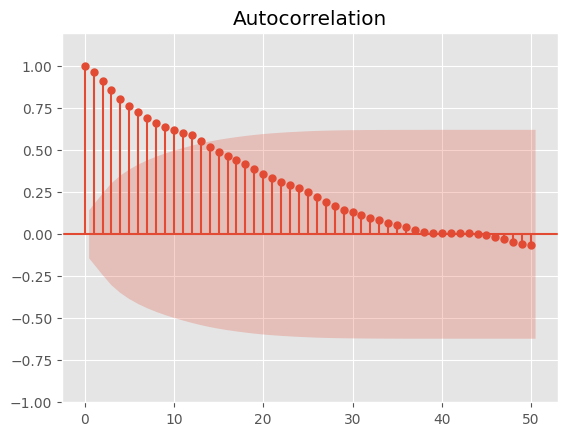

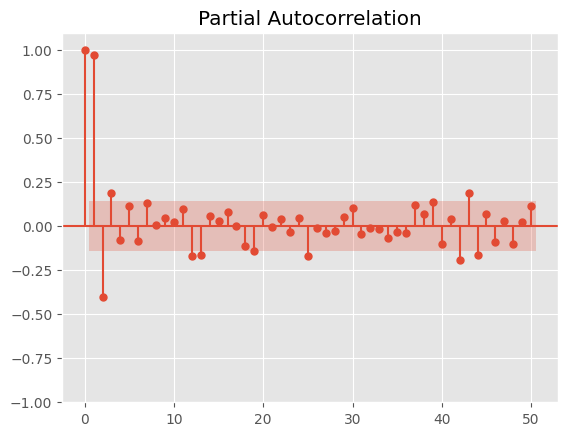

cotton


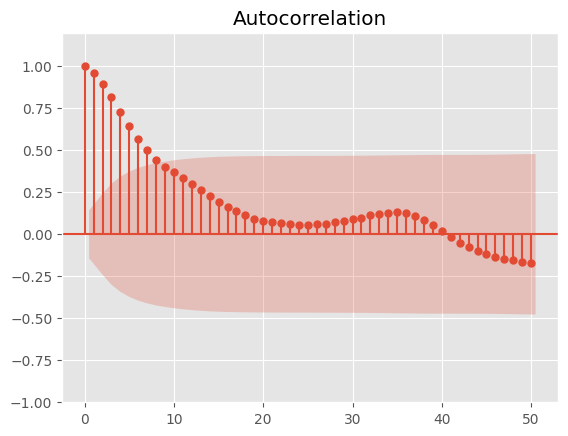

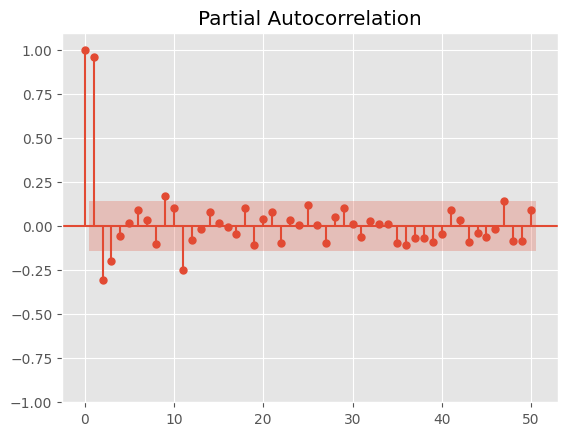

corn


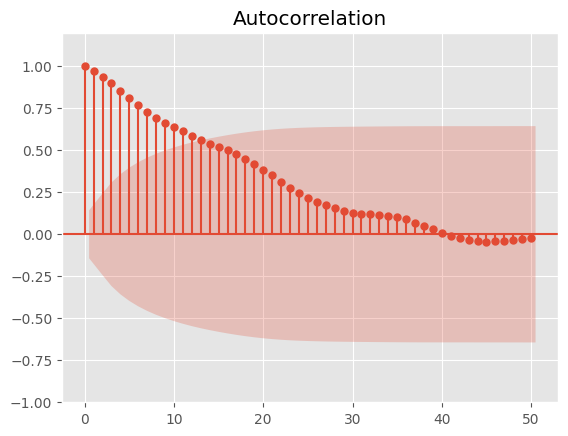

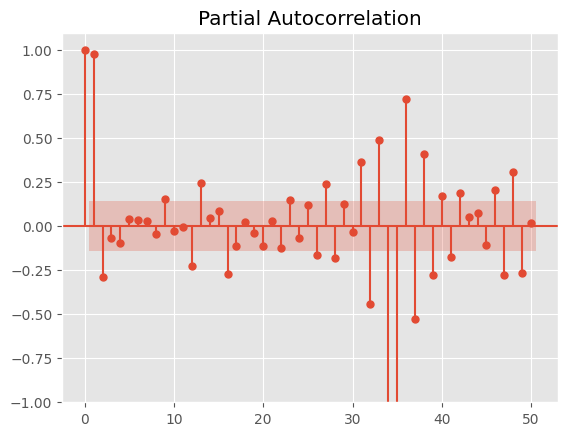

coffee


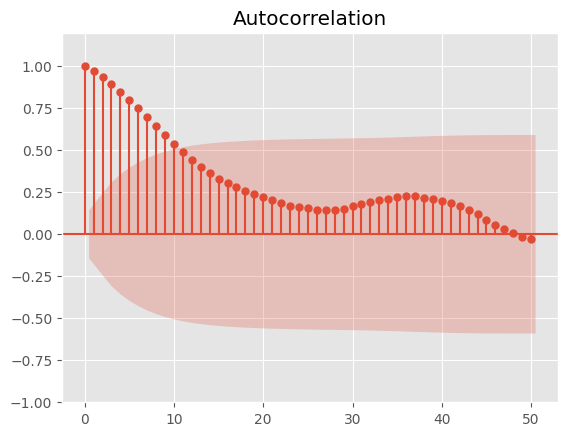

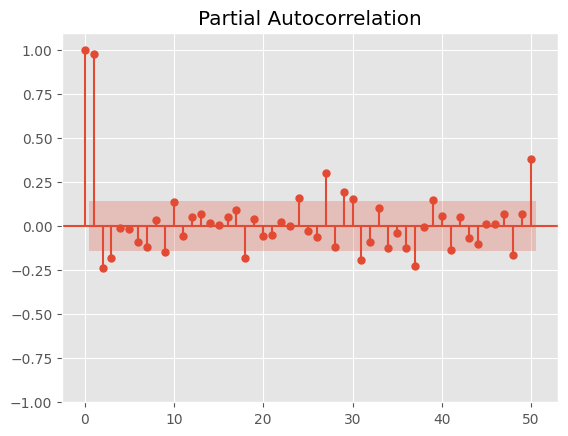

soybean


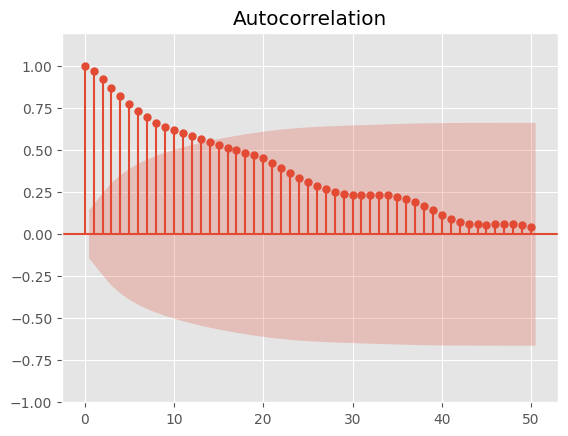

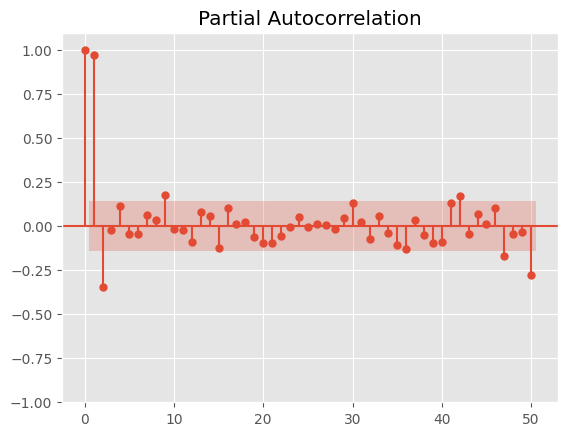

soybean_oil


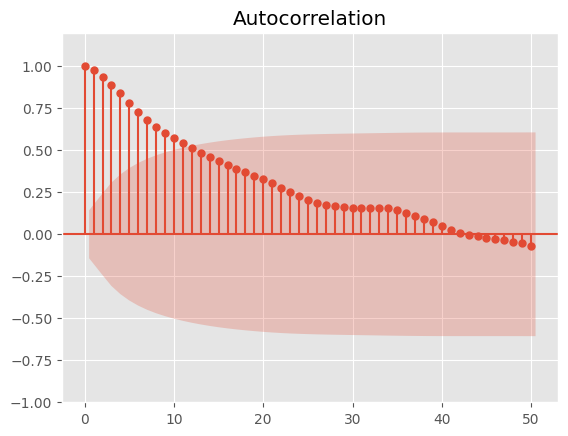

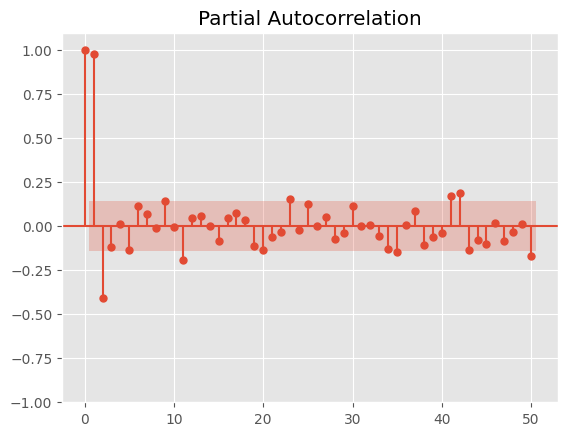

aluminum


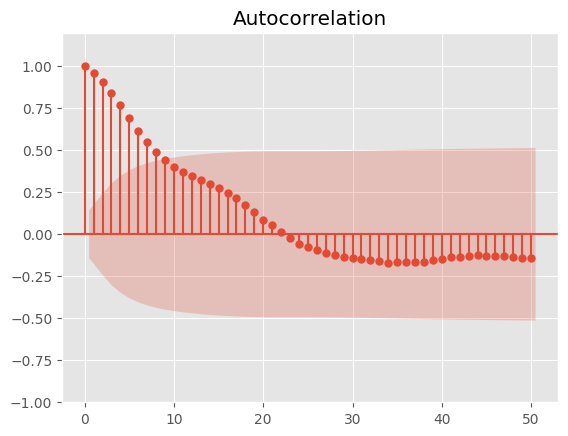

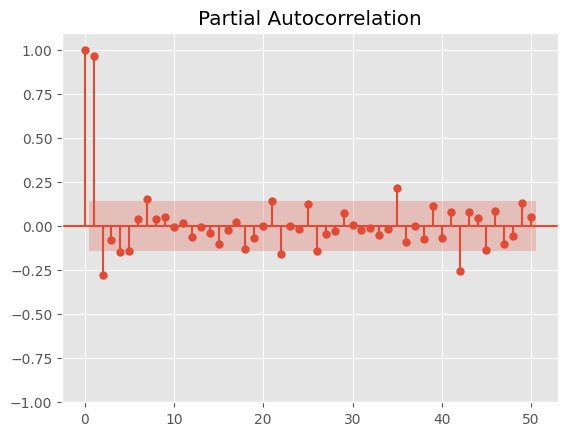

In [44]:
#Auto Correlation and Partial autocorrelation charts for exploration
for col in all_prices_M_train.columns:
  print(col)
  plot_acf(all_prices_M_train[col], lags = 50)
  plt.ylim(-1, 1.2)
  plt.show()
  plot_pacf(all_prices_M_train[col], lags = 50)
  plt.ylim(-1, 1.1)
  plt.show()

In [45]:
for col in all_prices_M_train.columns:
  print(col)
  auto_arima(all_prices_M_train[col], trace = True)

sugar
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1091.029, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1056.831, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1083.770, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1096.112, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1058.769, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1095.024, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1094.932, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1092.904, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1098.079, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1096.269, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1096.878, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1085.738, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1094.866, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.641 seconds
cot

## Aluminum ARIMA model

In [46]:
A_model_aluminum = ARIMA(all_prices_M_train['aluminum'], order = (3,1,3))
predictor_aluminum = A_model_aluminum.fit()
predictor_aluminum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               aluminum   No. Observations:                  189
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1131.482
Date:                Wed, 19 Apr 2023   AIC                           2276.964
Time:                        23:19:06   BIC                           2299.619
Sample:                    10-31-2002   HQIC                          2286.143
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0153      0.239      4.241      0.000       0.546       1.484
ar.L2         -0.6343      0.370     -1.713      0.087      -1.360       0.092
ar.L3          0.1015      0.258      0.393      0.695      -0.405       0.608
ma.L1         -0.7859      0.265     -2.965      0.003      -1.305      -0.266
ma.L2          0.4842      0.365      1.325      0.185      -0.232       1.200
ma.L3          0.1629      0.236      0.690      0.490      -0.300       0.625
sigma2      9873.7916    783.905     12.596      0.000    8337.366    1.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                41.72
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
Predicted_results_aluminum = predictor_aluminum.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

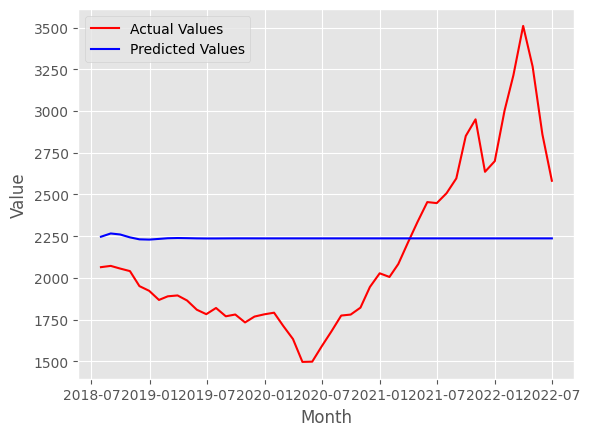

In [48]:
plt.plot(all_prices_M_test['aluminum'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_aluminum,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()

In [49]:
#performace metrics Soy bean oil ARIMA
RMSE_ARIMA_aluminum = math.sqrt(mean_squared_error(all_prices_M_test['aluminum'], Predicted_results_aluminum))
Rsquare_ARIMA_aluminum = r2_score(all_prices_M_test['aluminum'], Predicted_results_aluminum)

In [50]:
RMSE_ARIMA_aluminum

505.2406577643067

## Sugar ARIMA model

In [51]:
A_model_sugar = ARIMA(all_prices_M_train['sugar'], order = (6,0,7))
predictor_sugar = A_model_sugar.fit()
predictor_sugar.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sugar   No. Observations:                  189
Model:                 ARIMA(6, 0, 7)   Log Likelihood                 556.174
Date:                Wed, 19 Apr 2023   AIC                          -1082.348
Time:                        23:19:08   BIC                          -1033.722
Sample:                    10-31-2002   HQIC                         -1062.648
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1446      0.033      4.382      0.000       0.080       0.209
ar.L1          1.5690      1.131      1.387      0.165      -0.647       3.785
ar.L2         -1.0400      1.414     -0.736      0.462      -3.811       1.731
ar.L3          0.4557      1.482      0.308      0.758      -2.449       3.360
ar.L4         -0.4078      1.238     -0.329      0.742      -2.835       2.019
ar.L5          0.8901      0.991      0.898      0.369      -1.052       2.832
ar.L6         -0.4951      0.853     -0.580      0.562      -2.167       1.177
ma.L1         -0.0760      1.146     -0.066      0.947      -2.322       2.170
ma.L2          0.1074      0.826      0.130      0.897      -1.512       1.727
ma.L3          0.2182      0.869      0.251      0.802      -1.485       1.921
ma.L4          0.2626      0.745      0.352      0.725      -1.198       1.723
ma.L5         -0.2674      0.903     -0.296      0.767      -2.038       1.503
ma.L6         -0.2795      0.454     -0.615      0.538      -1.170       0.611
ma.L7         -0.0326      0.117     -0.278      0.781      -0.262       0.197
sigma2         0.0002   1.51e-05     10.590      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                77.18
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
Predicted_results_sugar = predictor_sugar.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

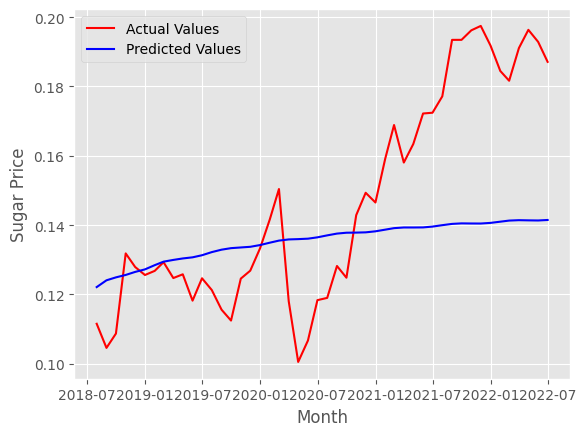

In [53]:
plt.plot(all_prices_M_test['sugar'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_sugar,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Sugar Price')
plt.legend()

In [54]:
#performace metrics Sugar ARIMA
RMSE_ARIMA_sugar = math.sqrt(mean_squared_error(all_prices_M_test['sugar'], Predicted_results_sugar))
Rsquare_ARIMA_sugar = r2_score(all_prices_M_test['sugar'], Predicted_results_sugar)

In [55]:
RMSE_ARIMA_sugar

0.02885330600594616

## Cotton ARIMA model

In [56]:
A_model_cotton = ARIMA(all_prices_M_train['cotton'], order = (9,0,4))
predictor_cotton = A_model_cotton.fit()
predictor_cotton.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 cotton   No. Observations:                  189
Model:                 ARIMA(9, 0, 4)   Log Likelihood                 259.493
Date:                Wed, 19 Apr 2023   AIC                           -488.986
Time:                        23:19:09   BIC                           -440.360
Sample:                    10-31-2002   HQIC                          -469.287
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7123      0.100      7.138      0.000       0.517       0.908
ar.L1          0.0412      1.509      0.027      0.978      -2.917       2.999
ar.L2         -0.0510      1.083     -0.047      0.962      -2.174       2.072
ar.L3          0.5126      0.532      0.963      0.335      -0.530       1.556
ar.L4          0.3230      0.655      0.493      0.622      -0.961       1.607
ar.L5          0.0994      0.503      0.198      0.843      -0.887       1.085
ar.L6         -0.2244      0.375     -0.598      0.550      -0.960       0.511
ar.L7          0.0879      0.196      0.448      0.654      -0.297       0.472
ar.L8         -0.0549      0.329     -0.167      0.867      -0.699       0.589
ar.L9         -0.0337      0.287     -0.117      0.907      -0.597       0.530
ma.L1          1.1518      1.520      0.758      0.449      -1.828       4.131
ma.L2          1.4003      1.008      1.388      0.165      -0.576       3.377
ma.L3          0.9346      1.245      0.751      0.453      -1.505       3.374
ma.L4          0.4399      0.689      0.639      0.523      -0.910       1.790
sigma2         0.0036      0.000     16.583      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               993.09
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.53
Prob(H) (two-sided):                  0.78   Kurtosis:                        14.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
Predicted_results_cotton = predictor_cotton.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

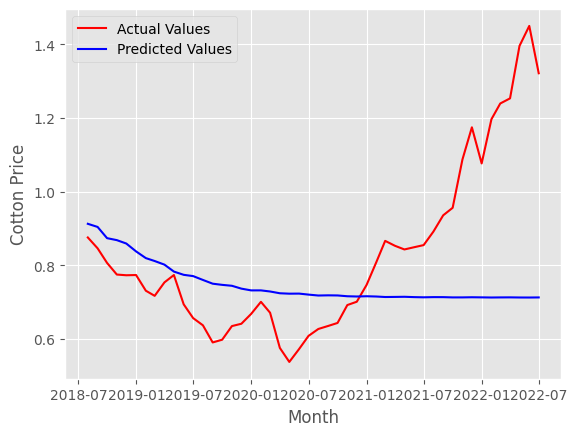

In [58]:
plt.plot(all_prices_M_test['cotton'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_cotton,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Cotton Price')
plt.legend()

In [59]:
#performace metrics cotton ARIMA
RMSE_ARIMA_cotton = math.sqrt(mean_squared_error(all_prices_M_test['cotton'], Predicted_results_cotton))
Rsquare_ARIMA_cotton = r2_score(all_prices_M_test['cotton'], Predicted_results_cotton)

In [60]:
RMSE_ARIMA_cotton

0.257799108563674

## Corn ARIMA model

In [61]:
A_model_corn = ARIMA(all_prices_M_train['corn'], order = (3,1,5))
predictor_corn = A_model_corn.fit()
predictor_corn.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   corn   No. Observations:                  189
Model:                 ARIMA(3, 1, 5)   Log Likelihood                 -42.525
Date:                Wed, 19 Apr 2023   AIC                            103.049
Time:                        23:19:10   BIC                            132.177
Sample:                    10-31-2002   HQIC                           114.851
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9804      0.066     14.890      0.000       0.851       1.109
ar.L2          0.6399      0.100      6.397      0.000       0.444       0.836
ar.L3         -0.8630      0.062    -13.993      0.000      -0.984      -0.742
ma.L1         -0.7229      0.769     -0.941      0.347      -2.229       0.783
ma.L2         -0.8932      1.307     -0.683      0.494      -3.455       1.668
ma.L3          0.8136      0.619      1.315      0.189      -0.399       2.026
ma.L4          0.0437      0.093      0.469      0.639      -0.139       0.227
ma.L5          0.0589      0.082      0.723      0.470      -0.101       0.219
sigma2         0.0905      0.065      1.399      0.162      -0.036       0.217
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               149.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
Predicted_results_corn = predictor_corn.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

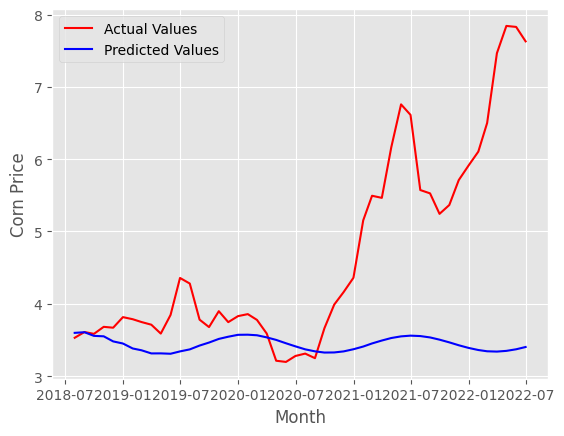

In [63]:
plt.plot(all_prices_M_test['corn'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_corn,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Corn Price')
plt.legend()

In [64]:
#performace metrics corn ARIMA
RMSE_ARIMA_corn = math.sqrt(mean_squared_error(all_prices_M_test['corn'], Predicted_results_corn))
Rsquare_ARIMA_corn = r2_score(all_prices_M_test['corn'], Predicted_results_corn)

In [65]:
RMSE_ARIMA_corn

1.8382735266248653

## Coffee ARIMA model

In [66]:
A_model_coffee = ARIMA(all_prices_M_train['coffee'], order = (4,1,5))
predictor_coffee = A_model_coffee.fit()
predictor_coffee.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 coffee   No. Observations:                  189
Model:                 ARIMA(4, 1, 5)   Log Likelihood                 193.151
Date:                Wed, 19 Apr 2023   AIC                           -366.302
Time:                        23:19:11   BIC                           -333.938
Sample:                    10-31-2002   HQIC                          -353.189
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4600      0.261     -1.762      0.078      -0.972       0.052
ar.L2          0.8358      0.201      4.152      0.000       0.441       1.230
ar.L3          0.6721      0.203      3.304      0.001       0.273       1.071
ar.L4         -0.1218      0.242     -0.503      0.615      -0.596       0.352
ma.L1          0.7021      0.273      2.568      0.010       0.166       1.238
ma.L2         -0.5941      0.302     -1.968      0.049      -1.186      -0.002
ma.L3         -0.7212      0.212     -3.401      0.001      -1.137      -0.306
ma.L4         -0.1456      0.306     -0.476      0.634      -0.745       0.454
ma.L5         -0.2323      0.106     -2.187      0.029      -0.440      -0.024
sigma2         0.0072      0.001     10.722      0.000       0.006       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.38
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
Predicted_results_coffee = predictor_coffee.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

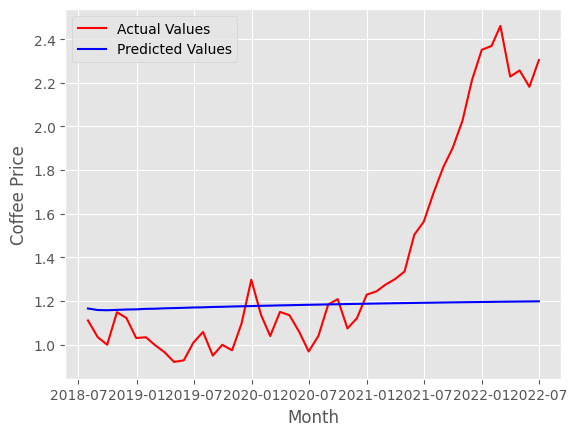

In [68]:
plt.plot(all_prices_M_test['coffee'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_coffee,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Coffee Price')
plt.legend()

In [69]:
#performace metrics Soy bean oil ARIMA
RMSE_ARIMA_coffee = math.sqrt(mean_squared_error(all_prices_M_test['coffee'], Predicted_results_coffee))
Rsquare_ARIMA_coffee = r2_score(all_prices_M_test['coffee'], Predicted_results_coffee)

In [70]:
RMSE_ARIMA_coffee

0.5086124942858565

## Soybean ARIMA model

In [71]:
A_model_soybean = ARIMA(all_prices_M_train['soybean'], order = (2,1,6))
predictor_soybean = A_model_soybean.fit()
predictor_soybean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                soybean   No. Observations:                  189
Model:                 ARIMA(2, 1, 6)   Log Likelihood                -172.426
Date:                Wed, 19 Apr 2023   AIC                            362.852
Time:                        23:19:12   BIC                            391.980
Sample:                    10-31-2002   HQIC                           374.654
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0055      0.299     -0.018      0.985      -0.591       0.580
ar.L2          0.6920      0.252      2.741      0.006       0.197       1.187
ma.L1          0.3624      0.304      1.190      0.234      -0.234       0.959
ma.L2         -0.5639      0.241     -2.343      0.019      -1.036      -0.092
ma.L3         -0.3552      0.112     -3.181      0.001      -0.574      -0.136
ma.L4         -0.1781      0.097     -1.840      0.066      -0.368       0.012
ma.L5          0.0264      0.093      0.285      0.776      -0.155       0.208
ma.L6         -0.0408      0.099     -0.412      0.680      -0.235       0.153
sigma2         0.3658      0.029     12.795      0.000       0.310       0.422
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.34
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
Predicted_results_soybean = predictor_soybean.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

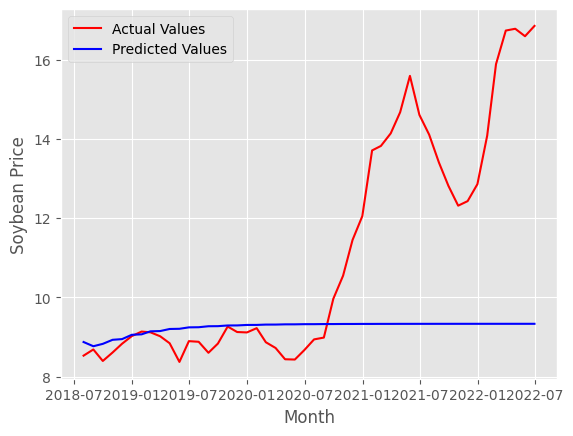

In [73]:
plt.plot(all_prices_M_test['soybean'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_soybean,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Soybean Price')
plt.legend()

In [74]:
#performace metrics Soy bean oil ARIMA
RMSE_ARIMA_soybean = math.sqrt(mean_squared_error(all_prices_M_test['soybean'], Predicted_results_soybean))
Rsquare_ARIMA_soybean = r2_score(all_prices_M_test['soybean'], Predicted_results_soybean)

In [75]:
RMSE_ARIMA_soybean

3.367017508721487

## Soybean oil ARIMA model

In [76]:
A_model_soybean_oil = ARIMA(all_prices_M_train['soybean_oil'], order = (3,1,4))
predictor_soybean_oil = A_model_soybean_oil.fit()
predictor_soybean_oil.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            soybean_oil   No. Observations:                  189
Model:                 ARIMA(3, 1, 4)   Log Likelihood                 476.759
Date:                Wed, 19 Apr 2023   AIC                           -937.517
Time:                        23:19:13   BIC                           -911.626
Sample:                    10-31-2002   HQIC                          -927.027
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4635      0.309      1.499      0.134      -0.143       1.070
ar.L2         -0.1148      0.206     -0.558      0.577      -0.518       0.288
ar.L3         -0.0926      0.268     -0.346      0.730      -0.618       0.432
ma.L1         -0.0302      0.302     -0.100      0.920      -0.621       0.561
ma.L2          0.1705      0.265      0.642      0.521      -0.350       0.691
ma.L3          0.0222      0.226      0.098      0.922      -0.420       0.464
ma.L4          0.3162      0.123      2.576      0.010       0.076       0.557
sigma2         0.0004   3.25e-05     11.220      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                58.55
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.54
Prob(H) (two-sided):                  0.37   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
Predicted_results_soybean_oil = predictor_soybean_oil.predict(start= len(all_prices_M_train), end = (len(all_prices_M_train)+len(all_prices_M_test) - 1), typ = 'levels')

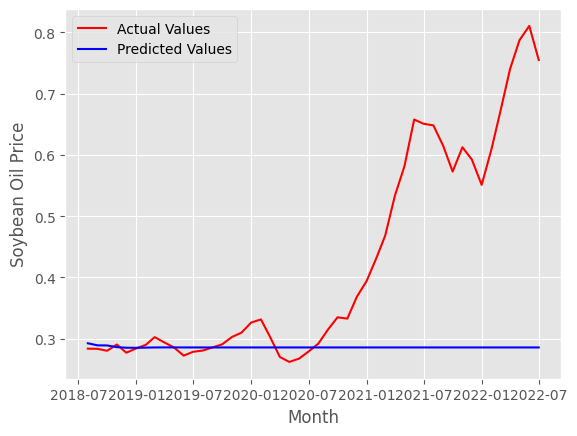

In [78]:
plt.plot(all_prices_M_test['soybean_oil'],color = 'red',label = 'Actual Values')
plt.plot(Predicted_results_soybean_oil,color = 'blue',label = 'Predicted Values')
plt.xlabel('Month')
plt.ylabel('Soybean Oil Price')
plt.legend()

In [79]:
#performace metrics Soy bean oil ARIMA
RMSE_ARIMA_soybean_oil = math.sqrt(mean_squared_error(all_prices_M_test['soybean_oil'], Predicted_results_soybean_oil))
Rsquare_ARIMA_soybean_oil = r2_score(all_prices_M_test['soybean_oil'], Predicted_results_soybean_oil)

In [80]:
RMSE_ARIMA_soybean_oil

0.21916021303429323

##ARIMA Results Comments <a id="sec6.2"></a>

You can see from the charts that there is quite a flat line of predictions in comparison to the actual values. The large difference is in part because of the large increases in price due to the pandemic, the other is because it is a prediction based on moving averages. It may not be the most effective predictions, but they will be dependable (for good and bad) and easily understood.

The values of RMSE will be used below to compare to the LSTM model in my final results section.

## LSTM Models <a id="sec6.3"></a>

### Pre-processing and Setup for LTSM

Split dataframes are better for this model, producing the least amount of errors while building these models.

In [81]:
#Scaling the data is essential for creating this NN model. This will be reverted further along.
sc = MinMaxScaler(feature_range= (0,1))
sc2 = MinMaxScaler(feature_range= (-1,1))


In [82]:
#Parameter grid for LSTM hyperparpmeter Grid Search
param_grid = {
    'units': [50, 60, 70, 200, 300],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop']
}

In [83]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

## LSTM Aluminum <a id="sec3.1"></a>

### Individual Pre-Processing - Aluminum

In [84]:
aluminum_LSTM = aluminum.resample('M').mean()

In [85]:
#Test and train split
x7 = len(aluminum_LSTM)
size7 = int(x7 * 0.8)
index7 = x7 - size7
aluminum_LSTM_train = aluminum_LSTM.iloc[:size7,].values
aluminum_LSTM_test = aluminum_LSTM.iloc[size7:,].values

In [86]:
#Scaling
aluminum_LSTM_train_scaled = sc.fit_transform(aluminum_LSTM_train)
aluminum_LSTM_test_scaled = sc.fit_transform(aluminum_LSTM_test)

In [87]:
#Lists for X train and Y train
x_train_al = []
y_train_al = []
#Window size, 1 year
WS = 11
#Creating arrays
for i in range(WS, len(aluminum_LSTM_train_scaled)):
  x_train_al.append(aluminum_LSTM_train_scaled[i-WS:i,0:1])
  y_train_al.append(aluminum_LSTM_train_scaled[i,0])

x_train_al, y_train_al =np.array(x_train_al), np.array(y_train_al)

Grid Search for Aluminum Hyperparameters

In [88]:
def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_al.shape[1], x_train_al.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [89]:
model_al_tune = KerasRegressor(build_fn=create_model, verbose=0)

In [90]:
grid_al = GridSearchCV(estimator=model_al_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [91]:
grid_result_al = grid_al.fit(x_train_al, y_train_al)

In [92]:
print("Best: %f using %s" % (grid_result_al.best_score_, grid_result_al.best_params_))

Best: -0.023848 using {'activation': 'tanh', 'optimizer': 'adam', 'units': 200}


### Developing LSTM model - Aluminum

In [93]:
#First Layer
model_al = Sequential()
model_al.add(LSTM(units = 200, activation = 'tanh', return_sequences = True, input_shape = (x_train_al.shape[1],1)))

#Dropout to avoid over fitting
model_al.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_al.add(LSTM(units = 200, return_sequences = True))
model_al.add(Dropout(0.2))

#Second hidden layer
model_al.add(LSTM(units = 200, return_sequences = True))
model_al.add(Dropout(0.2))


#Last layer- no return
model_al.add(LSTM(units = 200))
model_al.add(Dropout(0.2))

#Output
model_al.add(Dense(units = 1))

#Optimizer 
model_al.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#Fitting model
model_al.fit(x_train_al,y_train_al, epochs = 50, batch_size = 6)


Epoch 1/50
31/31 [==============================] - 9s 52ms/step - loss: 0.0630
Epoch 2/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0507
Epoch 3/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0452
Epoch 4/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0415
Epoch 5/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0377
Epoch 6/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0356
Epoch 7/50
31/31 [==============================] - 1s 47ms/step - loss: 0.0354
Epoch 8/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0297
Epoch 9/50
31/31 [==============================] - 1s 47ms/step - loss: 0.0304
Epoch 10/50
31/31 [==============================] - 1s 47ms/step - loss: 0.0215
Epoch 11/50
31/31 [==============================] - 1s 47ms/step - loss: 0.0220
Epoch 12/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0221
Epoch 13/50
31/31 [==================

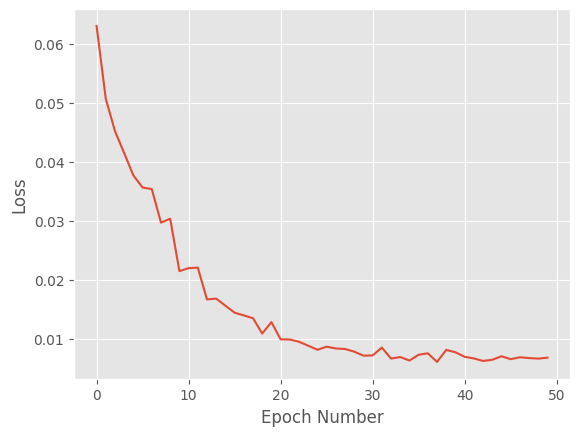

In [94]:
#Evlauating the number of Epochs
plt.plot(range(len(model_al.history.history['loss'])),model_al.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions - Aluminum

In [95]:
#Prediction setup
predict_test_al = [] 
batch_one_al = aluminum_LSTM_train_scaled[-WS:]
batch_new_al = batch_one_al.reshape((1,WS,1))

#Set number of predictions in range. I have set 49 months which is the length of the test data
for i in range(49):

  first_pred = model_al.predict(batch_new_al)[0]

  predict_test_al.append(first_pred)

  batch_new_al = np.append(batch_new_al[:,1:,:], [[first_pred]], axis = 1)

predict_test_al = np.array(predict_test_al)

predictions_al = sc.inverse_transform(predict_test_al[:49])


1/1 [==============================] - 0s 28ms/step


### Results - Aluminum

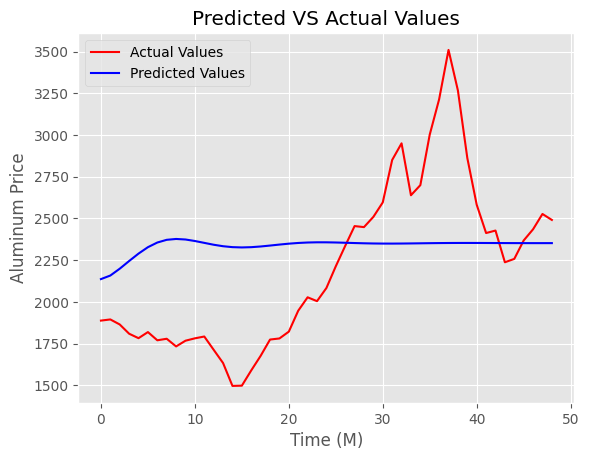

In [96]:
#Plot comparison between predicted and actual values
plt.plot(aluminum_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_al, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Aluminum Price')
plt.legend()
plt.show()

In [97]:
#Performace metrics
Aluminum_RMSE = math.sqrt(mean_squared_error(aluminum_LSTM_test, predictions_al))

In [98]:
Aluminum_RMSE

502.53211929570585

In [99]:
mae(aluminum_LSTM_test, predictions_al)

425.33802130979285

## LSTM Sugar <a id="sec3.2"></a>

### Individual Pre-Processing for Sugar

In [100]:
sugar_LSTM = sugar.resample('M').mean()

In [101]:
x = len(sugar_LSTM)
size = int(x * 0.8)
index = x - size
sugar_LSTM_train = sugar_LSTM.iloc[:size,].values
sugar_LSTM_test = sugar_LSTM.iloc[size:,].values

In [102]:
sugar_LSTM_train_scaled = sc2.fit_transform(sugar_LSTM_train)
sugar_LSTM_test_scaled = sc2.fit_transform(sugar_LSTM_test)

In [103]:
#Lists for X train and Y train
x_train_su = []
y_train_su = []
#Window size
WS = 12
#creating arrays for model
for i in range(WS, len(sugar_LSTM_train_scaled)):
  x_train_su.append(sugar_LSTM_train_scaled[i-WS:i,0:1])
  y_train_su.append(sugar_LSTM_train_scaled[i,0])

x_train_su, y_train_su =np.array(x_train_su), np.array(y_train_su)

Grid Search for Sugar Hyperparameters

In [104]:
def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_su.shape[1], x_train_su.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [105]:
model_su_tune = KerasRegressor(build_fn=create_model, verbose=0)

In [106]:
grid_su = GridSearchCV(estimator=model_su_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [107]:
grid_result_su = grid_su.fit(x_train_su, y_train_su)

In [108]:
print("Best: %f using %s" % (grid_result_su.best_score_, grid_result_su.best_params_))

Best: -0.022491 using {'activation': 'relu', 'optimizer': 'rmsprop', 'units': 200}


### Developing LSTM model - Sugar

In [109]:
#First Layer
model_su = Sequential()
model_su.add(LSTM(units = 200, activation = 'relu', return_sequences = True, input_shape = (x_train_su.shape[1],1)))

#Dropout to avoid over fitting
model_su.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_su.add(LSTM(units = 200, return_sequences = True))
model_su.add(Dropout(0.2))

#Second hidden layer
model_su.add(LSTM(units = 200, return_sequences = True))
model_su.add(Dropout(0.2))

#Last layer- no return
model_su.add(LSTM(units = 200))
model_su.add(Dropout(0.2))

#Output
model_su.add(Dense(units = 1))

#Optimizer 
model_su.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#Fitting model
model_su.fit(x_train_su,y_train_su, epochs = 50, batch_size = 5)


Epoch 1/50
114/114 [==============================] - 12s 49ms/step - loss: 0.0751
Epoch 2/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0462
Epoch 3/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0376
Epoch 4/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0303
Epoch 5/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0244
Epoch 6/50
114/114 [==============================] - 5s 48ms/step - loss: 0.0206
Epoch 7/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0171
Epoch 8/50
114/114 [==============================] - 6s 50ms/step - loss: 0.0169
Epoch 9/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0147
Epoch 10/50
114/114 [==============================] - 6s 50ms/step - loss: 0.0132
Epoch 11/50
114/114 [==============================] - 6s 49ms/step - loss: 0.0117
Epoch 12/50
114/114 [==============================] - 6s 50ms/step - loss: 0.0109
Epoch 13/50


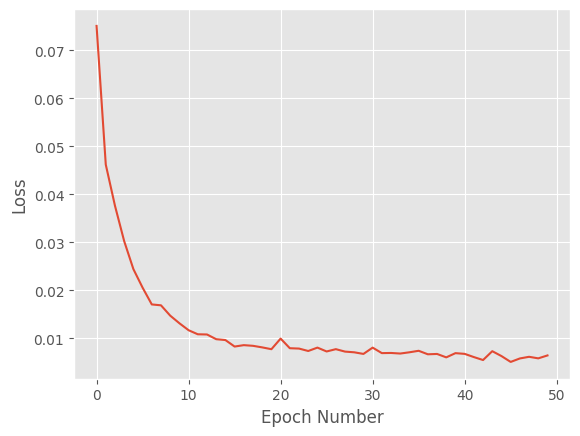

In [110]:
#Plotting loss in Epochs, determining if we are using the correct amount of epochs
plt.plot(range(len(model_su.history.history['loss'])),model_su.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions - Sugar

In [111]:
#Prediction setup
predict_test_su = []
batch_one_su = sugar_LSTM_train_scaled[-WS:]
batch_new_su = batch_one_su.reshape((1,WS,1))

#Set number of predictions in range.
for i in range(len(sugar_LSTM_test_scaled)):

  first_pred = model_su.predict(batch_new_su)[0]

  predict_test_su.append(first_pred)

  batch_new_su = np.append(batch_new_su[:,1:,:], [[first_pred]], axis = 1)

1/1 [==============================] - 0s 29ms/step


In [112]:
#changing to array
predict_test_su = np.array(predict_test_su)
#unscaling the values
predictions_su = sc2.inverse_transform(predict_test_su)

### Results - Sugar

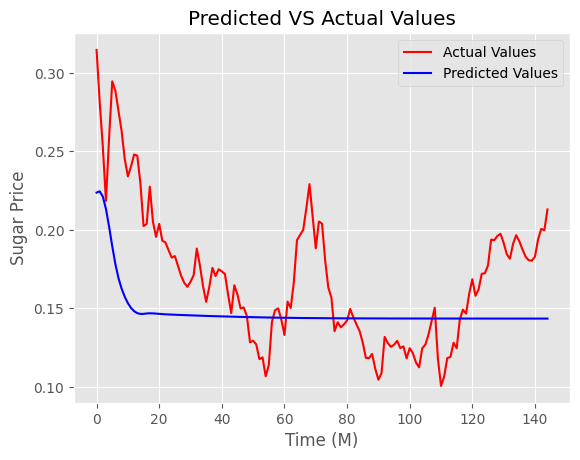

In [113]:
#Plot comparison between predicted and actual values
plt.plot(sugar_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_su, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Sugar Price')
plt.legend()
plt.show()

In [114]:
#Performace metrics
RMSE_sugar = math.sqrt(mean_squared_error(sugar_LSTM_test, predictions_su))
Rsquare_sugar = r2_score(sugar_LSTM_test, predictions_su)


In [115]:
RMSE_sugar

0.042438750327986836

In [116]:
mae(sugar_LSTM_test, predictions_su)

0.033755289349415026

##LSTM Cotton <a id="sec3.3"></a>

### Individual Pre-Processing - Cotton

In [117]:
cotton_LSTM = cotton.resample('M').mean()

In [118]:
#Test train Split
x2 = len(cotton_LSTM)
size2 = int(x2 * 0.8)
index2 = x2 - size2
cotton_LSTM_train = cotton_LSTM.iloc[:size2,].values
cotton_LSTM_test = cotton_LSTM.iloc[size2:,].values

In [119]:
cotton_LSTM_train_scaled = sc2.fit_transform(cotton_LSTM_train)
cotton_LSTM_test_scaled = sc2.fit_transform(cotton_LSTM_test)

In [120]:
#Lists for X and Y train
x_train_cot = []
y_train_cot = []
#Window size
WS = 10
#creating arrays for model
for i in range(WS, len(cotton_LSTM_train_scaled)):
  x_train_cot.append(cotton_LSTM_train_scaled[i-WS:i,0:1])
  y_train_cot.append(cotton_LSTM_train_scaled[i,0])

x_train_cot, y_train_cot =np.array(x_train_cot), np.array(y_train_cot)

Gridsearch for Cotton Hyperparameters 

In [121]:
def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_cot.shape[1], x_train_cot.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [122]:
model_cot_tune = KerasRegressor(build_fn=create_model, verbose=0)

In [123]:
grid_cot = GridSearchCV(estimator=model_cot_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [124]:
grid_result_cot = grid_cot.fit(x_train_cot, y_train_cot)

In [125]:
print("Best: %f using %s" % (grid_result_cot.best_score_, grid_result_cot.best_params_))

Best: -0.021247 using {'activation': 'tanh', 'optimizer': 'rmsprop', 'units': 50}


### Developing LSTM Model - Cotton

In [126]:
#First Layer
model_cot = Sequential()
model_cot.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, input_shape = (x_train_cot.shape[1],1)))

#Dropout to avoid over fitting
model_cot.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_cot.add(LSTM(units = 50, return_sequences = True))
model_cot.add(Dropout(0.2))

#Second hidden layer
model_cot.add(LSTM(units = 50, return_sequences = True))
model_cot.add(Dropout(0.2))

#Last layer- no return
model_cot.add(LSTM(units = 50))
model_cot.add(Dropout(0.2))

#Output
model_cot.add(Dense(units = 1))

#Optimizer
model_cot.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#fitting model
model_cot.fit(x_train_cot,y_train_cot, epochs = 50, batch_size = 6)


Epoch 1/50
80/80 [==============================] - 10s 19ms/step - loss: 0.0549
Epoch 2/50
80/80 [==============================] - 1s 18ms/step - loss: 0.0404
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 0.0377
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.0373
Epoch 5/50
80/80 [==============================] - 1s 19ms/step - loss: 0.0351
Epoch 6/50
80/80 [==============================] - 2s 19ms/step - loss: 0.0321
Epoch 7/50
80/80 [==============================] - 1s 19ms/step - loss: 0.0292
Epoch 8/50
80/80 [==============================] - 1s 19ms/step - loss: 0.0270
Epoch 9/50
80/80 [==============================] - 1s 18ms/step - loss: 0.0251
Epoch 10/50
80/80 [==============================] - 1s 18ms/step - loss: 0.0223
Epoch 11/50
80/80 [==============================] - 1s 19ms/step - loss: 0.0215
Epoch 12/50
80/80 [==============================] - 1s 18ms/step - loss: 0.0190
Epoch 13/50
80/80 [=================

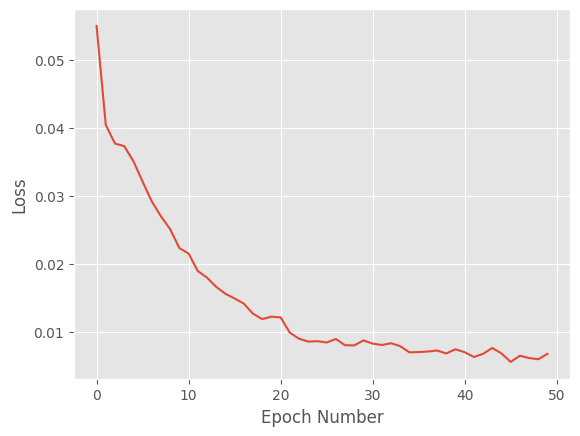

In [127]:
#Evlauating the number of Epochs
plt.plot(range(len(model_cot.history.history['loss'])),model_cot.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions - Cotton

In [128]:
#Prediction setup
predict_test_cot = [] 
batch_one_cot = cotton_LSTM_train_scaled[-WS:]
batch_new_cot = batch_one_cot.reshape((1,WS,1))

#Set number of predictions in range.
for i in range(len(cotton_LSTM_test_scaled)):

  first_pred = model_cot.predict(batch_new_cot)[0]

  predict_test_cot.append(first_pred)

  batch_new_cot = np.append(batch_new_cot[:,1:,:], [[first_pred]], axis = 1)

1/1 [==============================] - 0s 28ms/step


In [129]:
#Changing to array
predict_test_cot = np.array(predict_test_cot)
#Unscaling values
predictions_cot = sc2.inverse_transform(predict_test_cot)

### Results for Cotton

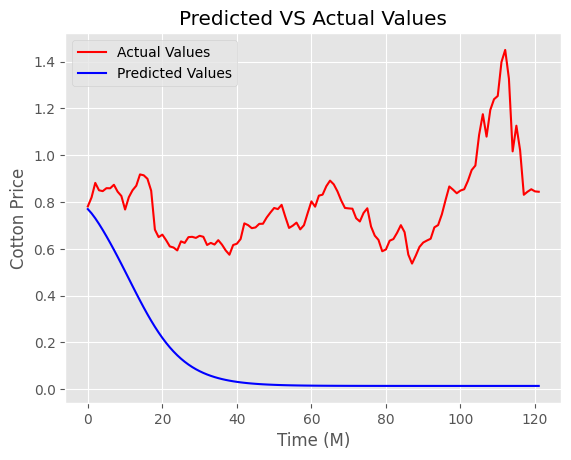

In [130]:
#Plot comparison between predicted and actual values
plt.plot(cotton_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_cot, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Cotton Price')
plt.legend()
plt.show()

In [131]:
#Performace metrics
RMSE_cotton = math.sqrt(mean_squared_error(cotton_LSTM_test, predictions_cot))

In [132]:
RMSE_cotton

0.7173651109058645

In [133]:
mae(cotton_LSTM_test, predictions_cot)

0.6718357316967694

## LSTM Corn <a id="sec3.4"></a>

### Individual pre-processing for Corn

In [134]:
corn_LSTM = corn.resample('M').mean()

In [135]:
x3 = len(corn_LSTM)
size3 = int(x3 * 0.8)
index3 = x3 - size3
corn_LSTM_train = corn_LSTM.iloc[:size3,].values
corn_LSTM_test = corn_LSTM.iloc[size3:,].values

In [136]:
corn_LSTM_train_scaled = sc2.fit_transform(corn_LSTM_train)
corn_LSTM_test_scaled = sc2.fit_transform(corn_LSTM_test)

In [137]:
#Lists for X train and Y train
x_train_cor = []
y_train_cor = []
#Window Size
WS = 12
#Creating arrays for model
for i in range(WS,len(corn_LSTM_train_scaled)):
  x_train_cor.append(corn_LSTM_train_scaled[i-WS:i,0:1])
  y_train_cor.append(corn_LSTM_train_scaled[i,0])

x_train_cor, y_train_cor =np.array(x_train_cor), np.array(y_train_cor)

Gridsearch for Corn Hyperparameters

In [138]:
def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_cor.shape[1], x_train_cor.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [139]:
model_cor_tune = KerasRegressor(build_fn=create_model, verbose=0)

In [140]:
grid_cor = GridSearchCV(estimator=model_cor_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [141]:
grid_result_cor = grid_cor.fit(x_train_cor, y_train_cor)

In [142]:
print("Best: %f using %s" % (grid_result_cor.best_score_, grid_result_cor.best_params_))

Best: -0.022904 using {'activation': 'tanh', 'optimizer': 'rmsprop', 'units': 300}


### Developing LSTM model for Corn

In [143]:
#First layer
model_cor = Sequential()
model_cor.add(LSTM(units = 200, activation = 'relu', return_sequences = True, input_shape = (x_train_cor.shape[1],1)))

#Dropout to avoid over fitting
model_cor.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_cor.add(LSTM(units = 200, return_sequences = True))
model_cor.add(Dropout(0.2))

#Second hidden layer
model_cor.add(LSTM(units = 200, return_sequences = True))
model_cor.add(Dropout(0.2))

#Last layer- no return
model_cor.add(LSTM(units = 200))
model_cor.add(Dropout(0.2))

#Output
model_cor.add(Dense(units = 1))

#Optimizer
model_cor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#Fitting model
model_cor.fit(x_train_cor,y_train_cor, epochs = 50, batch_size = 6)


Epoch 1/50
100/100 [==============================] - 12s 51ms/step - loss: 0.0695
Epoch 2/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0406
Epoch 3/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0334
Epoch 4/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0288
Epoch 5/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0271
Epoch 6/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0216
Epoch 7/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0181
Epoch 8/50
100/100 [==============================] - 5s 49ms/step - loss: 0.0161
Epoch 9/50
100/100 [==============================] - 5s 51ms/step - loss: 0.0161
Epoch 10/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0145
Epoch 11/50
100/100 [==============================] - 5s 50ms/step - loss: 0.0120
Epoch 12/50
100/100 [==============================] - 5s 53ms/step - loss: 0.0112
Epoch 13/50


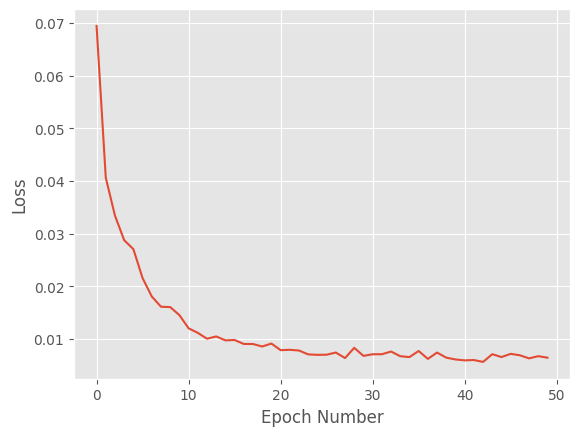

In [144]:
#Evaluating the number of epochs
plt.plot(range(len(model_cor.history.history['loss'])),model_cor.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions for Corn

In [145]:
#Prediction setup
predict_test_cor = [] 
batch_one_cor = corn_LSTM_train_scaled[-WS:]
batch_new_cor = batch_one_cor.reshape((1,WS,1))

#Set number of predictions in range
for i in range(len(corn_LSTM_test_scaled)):

  first_pred = model_cor.predict(batch_new_cor)[0]

  predict_test_cor.append(first_pred)

  batch_new_cor = np.append(batch_new_cor[:,1:,:], [[first_pred]], axis = 1)

1/1 [==============================] - 0s 28ms/step


In [146]:
#Changing to array
predict_test_cor = np.array(predict_test_cor)
#Unscaling values
predictions_cor = sc2.inverse_transform(predict_test_cor)

### Results for Corn

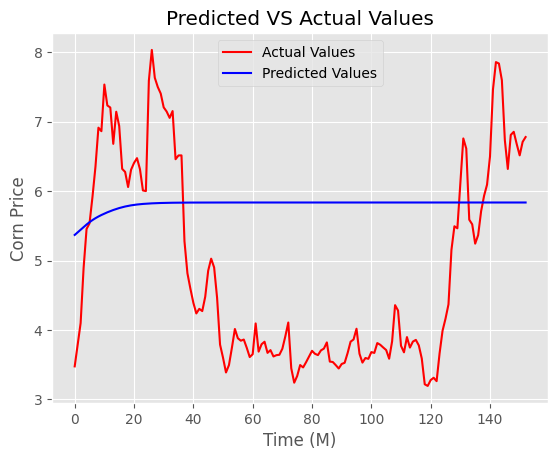

In [147]:
#Plot comparison between predicted and actual values
plt.plot(corn_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_cor, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Corn Price')
plt.legend()
plt.show()

In [148]:
#Performace metrics
RMSE_corn = math.sqrt(mean_squared_error(corn_LSTM_test, predictions_cor))

In [149]:
RMSE_corn

1.7238802156265998

In [150]:
mae(corn_LSTM_test, predictions_cor)

1.5645409348676236

## LSTM Coffee <a id="sec3.5"></a>

### Individual Pre-Processing for Coffee

In [151]:
coffee_LSTM = coffee.resample('M').mean()

In [152]:
x4 = len(coffee_LSTM)
size4 = int(x4 * 0.8)
index4 = x4 - size4
coffee_LSTM_train = coffee_LSTM.iloc[:size4,].values
coffee_LSTM_test = coffee_LSTM.iloc[size4:,].values

In [153]:
coffee_LSTM_train_scaled = sc2.fit_transform(coffee_LSTM_train)
coffee_LSTM_test_scaled = sc2.fit_transform(coffee_LSTM_test)

In [154]:
#Lists for X and Y train
x_train_cof = []
y_train_cof = []
#Window size
WS = 10
#Creating arrays for model
for i in range(WS, len(coffee_LSTM_train_scaled)):
  x_train_cof.append(coffee_LSTM_train_scaled[i-WS:i,0:1])
  y_train_cof.append(coffee_LSTM_train_scaled[i,0])

x_train_cof, y_train_cof =np.array(x_train_cof), np.array(y_train_cof)

Gridsearch for Coffee hyperparameters 

In [155]:
def create_model_cof(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_cof.shape[1], x_train_cof.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [156]:
model_cof_tune = KerasRegressor(build_fn=create_model_cof, verbose=0)

In [157]:
grid_cof = GridSearchCV(estimator=model_cof_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [158]:
grid_result_cof = grid_cof.fit(x_train_cof, y_train_cof)

In [159]:
print("Best: %f using %s" % (grid_result_cof.best_score_, grid_result_cof.best_params_))

Best: -0.040449 using {'activation': 'relu', 'optimizer': 'adam', 'units': 300}


### Developing LSTM model for Coffee

In [160]:
#First Layer
model_cof = Sequential()
model_cof.add(LSTM(units = 300, activation = 'relu', return_sequences = True, input_shape = (x_train_cof.shape[1],1)))

#Dropout to avoid over fitting
model_cof.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_cof.add(LSTM(units = 300, return_sequences = True))
model_cof.add(Dropout(0.2))

#Second hidden layer
model_cof.add(LSTM(units = 300, return_sequences = True))
model_cof.add(Dropout(0.2))

#Last layer- no return
model_cof.add(LSTM(units = 300))
model_cof.add(Dropout(0.2))

#Output
model_cof.add(Dense(units = 1))

#Optimizer 
model_cof.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#Fitting model
model_cof.fit(x_train_cof,y_train_cof, epochs = 50, batch_size = 5)


Epoch 1/50
94/94 [==============================] - 11s 51ms/step - loss: 0.0993
Epoch 2/50
94/94 [==============================] - 4s 47ms/step - loss: 0.0552
Epoch 3/50
94/94 [==============================] - 4s 46ms/step - loss: 0.0390
Epoch 4/50
94/94 [==============================] - 4s 46ms/step - loss: 0.0310
Epoch 5/50
94/94 [==============================] - 5s 48ms/step - loss: 0.0268
Epoch 6/50
94/94 [==============================] - 5s 48ms/step - loss: 0.0234
Epoch 7/50
94/94 [==============================] - 5s 50ms/step - loss: 0.0191
Epoch 8/50
94/94 [==============================] - 4s 46ms/step - loss: 0.0186
Epoch 9/50
94/94 [==============================] - 4s 47ms/step - loss: 0.0183
Epoch 10/50
94/94 [==============================] - 5s 49ms/step - loss: 0.0176
Epoch 11/50
94/94 [==============================] - 4s 47ms/step - loss: 0.0167
Epoch 12/50
94/94 [==============================] - 5s 48ms/step - loss: 0.0165
Epoch 13/50
94/94 [=================

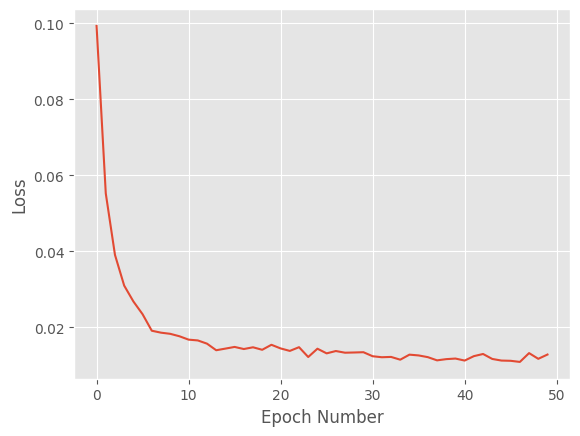

In [161]:
#Evaluating the number of epochs
plt.plot(range(len(model_cof.history.history['loss'])),model_cof.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions for Coffee

In [162]:
#Prediction setup
predict_test_cof = [] 
batch_one_cof = coffee_LSTM_train_scaled[-WS:]
batch_new_cof = batch_one_cof.reshape((1,WS,1))

#Set number of predictions in range.
for i in range(len(coffee_LSTM_test_scaled)):

  first_pred = model_cof.predict(batch_new_cof)[0]

  predict_test_cof.append(first_pred)

  batch_new_cof = np.append(batch_new_cof[:,1:,:], [[first_pred]], axis = 1)

1/1 [==============================] - 0s 30ms/step


In [163]:
#Changing to array
predict_test_cof = np.array(predict_test_cof)
#Unscaling values
predictions_cof = sc2.inverse_transform(predict_test_cof)

### Results for Coffee

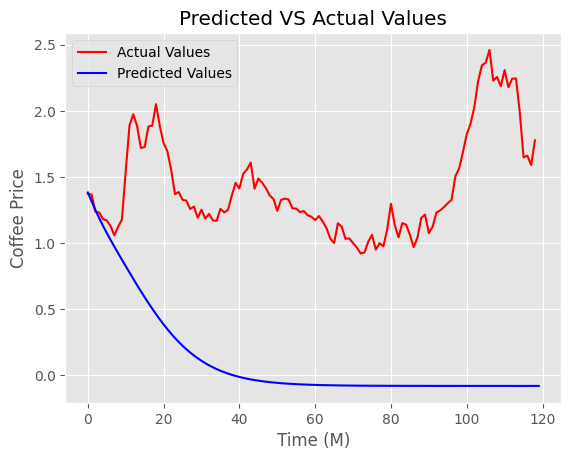

In [164]:
#Plot comparison between predicted and actual values
plt.plot(coffee_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_cof, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Coffee Price')
plt.legend()
plt.show()

In [165]:
coffee_LSTM_test = coffee_LSTM_test[~np.isnan(coffee_LSTM_test)]
#performace metrics
RMSE_coffee = math.sqrt(mean_squared_error(coffee_LSTM_test, predictions_cof[:119]))

In [166]:
RMSE_coffee

1.4051282061944668

In [167]:
mae(coffee_LSTM_test, predictions_cof[:119])

1.3086615853416776

## LSTM Soybean <a id="sec3.6"></a>

### Individual Pre-Processing for Soybean

In [168]:
soybean_LSTM = soybean.resample('M').mean()

In [169]:
x5 = len(soybean_LSTM)
size5 = int(x5 * 0.8)
index5 = x5 - size5
soybean_LSTM_train = soybean_LSTM.iloc[:size5,].values
soybean_LSTM_test = soybean_LSTM.iloc[size5:,].values

In [170]:
soybean_LSTM_train_scaled = sc2.fit_transform(soybean_LSTM_train)
soybean_LSTM_test_scaled = sc2.fit_transform(soybean_LSTM_test)

In [171]:
#Lists for X an Y train
x_train_sb = []
y_train_sb = []
#Window size
WS = 10
#creating arrays for model
for i in range(WS, len(soybean_LSTM_train_scaled)):
  x_train_sb.append(soybean_LSTM_train_scaled[i-WS:i,0:1])
  y_train_sb.append(soybean_LSTM_train_scaled[i,0])

x_train_sb, y_train_sb =np.array(x_train_sb), np.array(y_train_sb)

Gridsearch for Soybean hyperparameters

In [172]:
def create_model_sb(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_sb.shape[1], x_train_sb.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [173]:
model_sb_tune = KerasRegressor(build_fn=create_model_sb, verbose=0)

In [174]:
grid_sb = GridSearchCV(estimator=model_sb_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [175]:
grid_result_sb = grid_sb.fit(x_train_sb, y_train_sb)

In [176]:
print("Best: %f using %s" % (grid_result_sb.best_score_, grid_result_sb.best_params_))

Best: -0.036753 using {'activation': 'tanh', 'optimizer': 'adam', 'units': 200}


### Developing LSTM Model for Soybean

In [177]:
#First Layer
model_sb = Sequential()
model_sb.add(LSTM(units = 300, activation = 'tanh', return_sequences = True, input_shape = (x_train_sb.shape[1],1)))

#Dropout to avoid over fitting
model_sb.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_sb.add(LSTM(units = 300, return_sequences = True))
model_sb.add(Dropout(0.2))

#Second hidden layer
model_sb.add(LSTM(units =300, return_sequences = True))
model_sb.add(Dropout(0.2))

#Last layer- no return
model_sb.add(LSTM(units = 300))
model_sb.add(Dropout(0.2))

#Output
model_sb.add(Dense(units = 1))

#Optimizer
model_sb.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#Fitting model
model_sb.fit(x_train_sb,y_train_sb, epochs = 50, batch_size = 5)


Epoch 1/50
102/102 [==============================] - 10s 47ms/step - loss: 0.0731
Epoch 2/50
102/102 [==============================] - 4s 44ms/step - loss: 0.0472
Epoch 3/50
102/102 [==============================] - 4s 42ms/step - loss: 0.0386
Epoch 4/50
102/102 [==============================] - 5s 46ms/step - loss: 0.0261
Epoch 5/50
102/102 [==============================] - 4s 44ms/step - loss: 0.0215
Epoch 6/50
102/102 [==============================] - 4s 44ms/step - loss: 0.0175
Epoch 7/50
102/102 [==============================] - 5s 45ms/step - loss: 0.0147
Epoch 8/50
102/102 [==============================] - 4s 43ms/step - loss: 0.0139
Epoch 9/50
102/102 [==============================] - 5s 44ms/step - loss: 0.0108
Epoch 10/50
102/102 [==============================] - 5s 44ms/step - loss: 0.0108
Epoch 11/50
102/102 [==============================] - 4s 44ms/step - loss: 0.0121
Epoch 12/50
102/102 [==============================] - 4s 42ms/step - loss: 0.0116
Epoch 13/50


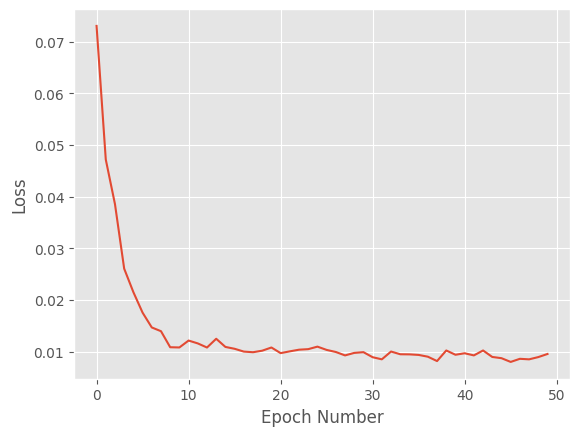

In [178]:
#Evaluating the number of epochs
plt.plot(range(len(model_sb.history.history['loss'])),model_sb.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions for Soybean

In [179]:
#Prediction steup
predict_test_sb = [] 
batch_one_sb = soybean_LSTM_train_scaled[-WS:]
batch_new_sb = batch_one_sb.reshape((1,WS,1))

#Set number of predictions in range.
for i in range(len(soybean_LSTM_test)):

  first_pred = model_sb.predict(batch_new_sb)[0]

  predict_test_sb.append(first_pred)

  batch_new_sb = np.append(batch_new_sb[:,1:,:], [[first_pred]], axis = 1)

1/1 [==============================] - 0s 33ms/step


In [180]:
#Changing to array
predict_test_sb = np.array(predict_test_sb)
#Unscaling values
predictions_sb = sc2.inverse_transform(predict_test_sb)

### Results for Soybean


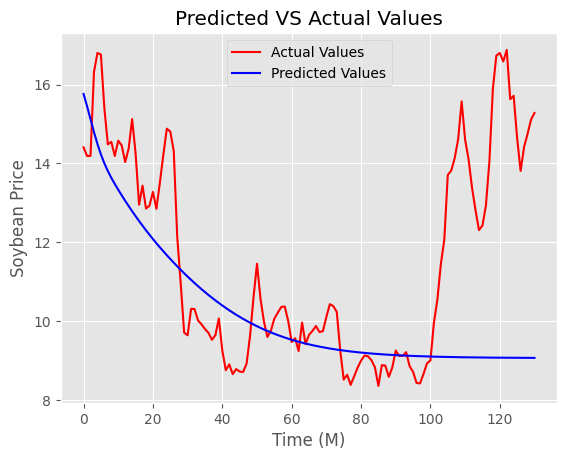

In [181]:
#Plot comparison between predicted and actual values
plt.plot(soybean_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_sb, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Soybean Price')
plt.legend()
plt.show()

In [182]:
#Performace metrics
RMSE_soybean = math.sqrt(mean_squared_error(soybean_LSTM_test, predictions_sb))

In [183]:
RMSE_soybean

2.7415217559025096

In [184]:
mae(soybean_LSTM_test, predictions_sb)

1.8143227754994755

## LSTM Soybean Oil <a id="sec3.7"></a>

### Individual Pre-Processing for Soybean Oil

In [185]:
soybean_oil_LSTM = soybean_oil.resample('M').mean()

In [186]:
x6 = len(soybean_oil_LSTM)
size6 = int(x6 * 0.8)
index6 = x6 - size6
soybean_oil_LSTM_train = soybean_oil_LSTM.iloc[:size6,].values
soybean_oil_LSTM_test = soybean_oil_LSTM.iloc[size6:,].values

In [187]:
soybean_oil_LSTM_train_scaled = sc2.fit_transform(soybean_oil_LSTM_train)
soybean_oil_LSTM_test_scaled = sc2.fit_transform(soybean_oil_LSTM_test)

In [188]:
#Lists for X an Y train
x_train_sbo = []
y_train_sbo = []
#Window size
WS = 12
#Creating arrays for model
for i in range(WS, len(soybean_oil_LSTM_train_scaled)):
  x_train_sbo.append(soybean_oil_LSTM_train_scaled[i-WS:i,0:1])
  y_train_sbo.append(soybean_oil_LSTM_train_scaled[i,0])

x_train_sbo, y_train_sbo =np.array(x_train_sbo), np.array(y_train_sbo)

Gridsearch for Soybean Oil Hyperparameters

In [189]:
def create_model_sbo(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(x_train_sbo.shape[1], x_train_sbo.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [190]:
model_sbo_tune = KerasRegressor(build_fn= create_model_sbo, verbose=0)

In [191]:
grid_sbo = GridSearchCV(estimator=model_sbo_tune, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [192]:
grid_result_sbo = grid_sbo.fit(x_train_sbo, y_train_sbo)

In [193]:
print("Best: %f using %s" % (grid_result_sbo.best_score_, grid_result_sbo.best_params_))

Best: -0.025069 using {'activation': 'tanh', 'optimizer': 'rmsprop', 'units': 60}


### Developing LSTM Model for Soybean Oil

In [ ]:
#First layer
model_sbo = Sequential()
model_sbo.add(LSTM(units = 200, activation = 'tanh', return_sequences = True, input_shape = (x_train_sbo.shape[1],1)))

#Dropout to avoid over fitting
model_sbo.add(Dropout(0.2))

#Next layer no input - first hidden layer
model_sbo.add(LSTM(units = 200, return_sequences = True))
model_sbo.add(Dropout(0.2))

#Second hidden layer
model_sbo.add(LSTM(units = 200, return_sequences = True))
model_sbo.add(Dropout(0.2))

#Last layer- no return
model_sbo.add(LSTM(units = 200))
model_sbo.add(Dropout(0.2))

#Output
model_sbo.add(Dense(units = 1))

#Optimizer 'rmsprop' - chosen through Gridsearch
model_sbo.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

#Fitting model
model_sbo.fit(x_train_sbo,y_train_sbo, epochs = 50, batch_size = 5)


Epoch 1/50
116/116 [==============================] - 11s 46ms/step - loss: 0.0728
Epoch 2/50
116/116 [==============================] - 5s 46ms/step - loss: 0.0437
Epoch 3/50
116/116 [==============================] - 5s 46ms/step - loss: 0.0327
Epoch 4/50
116/116 [==============================] - 5s 47ms/step - loss: 0.0237
Epoch 5/50
116/116 [==============================] - 5s 47ms/step - loss: 0.0206
Epoch 6/50
116/116 [==============================] - 5s 46ms/step - loss: 0.0157
Epoch 7/50
116/116 [==============================] - 5s 47ms/step - loss: 0.0146
Epoch 8/50
116/116 [==============================] - 5s 46ms/step - loss: 0.0118
Epoch 9/50
116/116 [==============================] - 5s 46ms/step - loss: 0.0111
Epoch 10/50
116/116 [==============================] - 6s 47ms/step - loss: 0.0099
Epoch 11/50
116/116 [==============================] - 5s 46ms/step - loss: 0.0097
Epoch 12/50
116/116 [==============================] - 5s 47ms/step - loss: 0.0091
Epoch 13/50


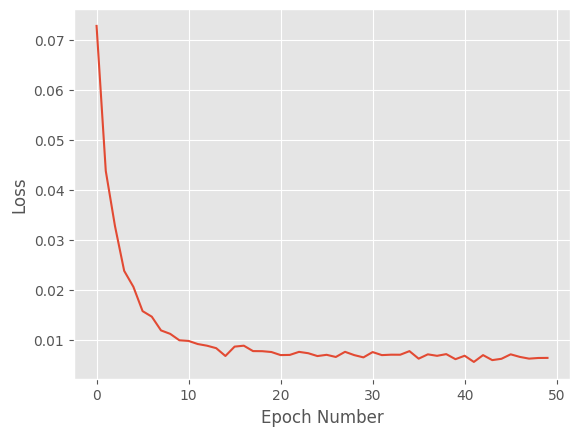

In [ ]:
#Evlauating the number of epochs
plt.plot(range(len(model_sbo.history.history['loss'])),model_sbo.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Predictions for Soybean Oil

In [ ]:
#Prediction setup
predict_test_sbo = [] 
batch_one_sbo = soybean_oil_LSTM_train_scaled[-WS:]
batch_new_sbo = batch_one_sbo.reshape((1,WS,1))

#Set number of predictions in range
for i in range(149):

  first_pred = model_sbo.predict(batch_new_sbo)[0]

  predict_test_sbo.append(first_pred)

  batch_new_sbo = np.append(batch_new_sbo[:,1:,:],[[first_pred]], axis = 1)

1/1 [==============================] - 0s 28ms/step


In [ ]:
#Changing to array
predict_test_sbo = np.array(predict_test_sbo)
#Unscaling values
predictions_sbo = sc2.inverse_transform(predict_test_sbo)

### Results for Soybean Oil

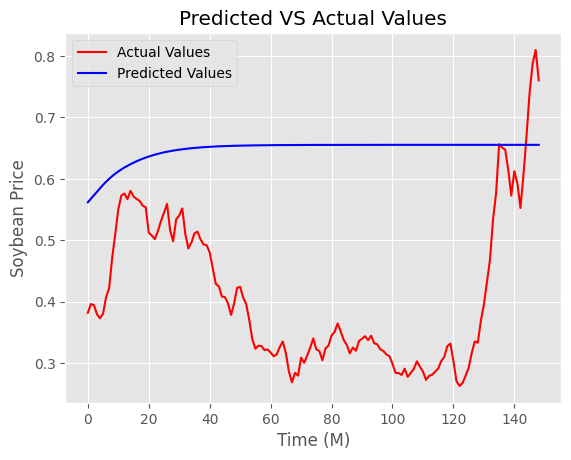

In [ ]:
#Plot comparison between predicted and actual values
plt.plot(soybean_oil_LSTM_test,color = 'red', label = 'Actual Values')
plt.plot(predictions_sbo, color = 'blue', label = 'Predicted Values')
plt.title('Predicted VS Actual Values')
plt.xlabel('Time (M)')
plt.ylabel('Soybean Price')
plt.legend()
plt.show()

In [ ]:
#Performace metrics
RMSE_soybean_oil = math.sqrt(mean_squared_error(soybean_oil_LSTM_test, predictions_sbo))

In [ ]:
RMSE_soybean_oil

0.2689092902261356

In [ ]:
mae(soybean_oil_LSTM_test, predictions_sbo)

0.24252537532362348

## Results

In [ ]:
#Aluminum
print('RMSE Aluminum - ARIMA')
print(RMSE_ARIMA_aluminum)

RMSE Aluminum - ARIMA
505.2406577643067


In [ ]:
print('RMSE Aluminum - LSTM')
print(Aluminum_RMSE)

RMSE Aluminum - LSTM
502.53211929570585


In [ ]:
#Sugar
print('RMSE Sugar - ARIMA')
print(RMSE_ARIMA_sugar)

RMSE Sugar - ARIMA
0.02885330600594616


In [ ]:
print('RMSE Sugar- LSTM')
print(RMSE_sugar)

RMSE Sugar- LSTM
0.042438750327986836


In [ ]:
#Cotton
print('RMSE Cotton - ARIMA')
print(RMSE_ARIMA_cotton)

RMSE Cotton - ARIMA
0.257799108563674


In [ ]:
print('RMSE Cotton - LSTM')
print(RMSE_cotton)

RMSE Cotton - LSTM
0.7173651109058645


In [ ]:
#Corn
print('RMSE Corn - ARIMA')
print(RMSE_ARIMA_corn)

RMSE Corn - ARIMA
1.8382735266248653


In [ ]:
print('RMSE Corn - LSTM')
print(RMSE_corn)

RMSE Corn - LSTM
1.7238802156265998


In [ ]:
#Coffee
print('RMSE Coffee - ARIMA')
print(RMSE_ARIMA_coffee)

RMSE Coffee - ARIMA
0.5086124942858565


In [ ]:
print('RMSE Coffee - LSTM')
print(RMSE_coffee)

RMSE Coffee - LSTM
1.4051282061944668


In [ ]:
#Soybean
print('RMSE Soybean - ARIMA')
print(RMSE_ARIMA_soybean)

RMSE Soybean - ARIMA
3.367017508721487


In [ ]:
print('RMSE Soybean - LSTM')
print(RMSE_soybean)

RMSE Soybean - LSTM
2.7415217559025096


In [ ]:
#Soybean oil
print('RMSE Soybean Oil - ARIMA')
print(RMSE_ARIMA_soybean_oil)

RMSE Soybean Oil - ARIMA
0.21916021303429323


In [ ]:
print('RMSE Soybean Oil - LSTM')
print(RMSE_soybean_oil)

RMSE Soybean Oil - LSTM
0.2689092902261356


The ARIMA model outperformed the LSTM model for every commodity. The LSTM model may depend more on seasonality and our data is not highly seasonal. The cyclical nature does not seem to benefit this recurrent neural network model. Of the two models, I would work with the ARIMA because of the better fit overall and the relative consistency of results produced. I had trouble getting consistent results from runtime to runtime with the LSTM model.

#Export

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/EDA/Final_Individual_Notebook_Stoker.ipynb" ./

!jupyter nbconvert --to html "Final_Individual_Notebook_Stoker.ipynb"

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/EDA/Final_Individual_Notebook_Stoker.ipynb': No such file or directory
[NbConvertApp] WARNING | pattern 'Final_Individual_Notebook_Stoker.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--Jupyt